# Olymploration: Who wins the most medals at the Olympics?

Rooted in rich history, symbolism and values associated with the Olympic games, Olympic medals are considered highly prestigious, often representing the pinnacle of athletic achievement. Winning an Olympic medal is a recognition of excellence on the international stage, and it often holds cultural and national significance. It is an opportunity for athletes from all nations, big or small, to transcend national boundaries and compete together. This tradition began in 1896 in Athens, Greece and with the exception of the games not being held due to the two world wars, the Summer games have been held every 4 years. The first Winter Olympics were held in Chamonix, France, in 1924. The goal of this project is to predict which country will win the most medals at the Olympic games. 

In [82]:
#import packages needed

import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import glob2 as glob
import missingno as msno
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score
from sklearn import preprocessing 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from imblearn.pipeline import Pipeline as ImbPipeline

In [83]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [84]:
#read in files
relative_path = "data/raw/*.csv" 
file_list = glob.glob(relative_path)

dataframes = []


if not file_list:
    print("No CSV files found in the specified path.")
else:
    file_list.sort() #to stop the order from changing

    # Loop through the sorted file list and read each CSV file into a df
    for file in file_list:
        try:
            df = pd.read_csv(file)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

In [85]:
 #name the dfs
df_athletes = dataframes[0]
df_event_results = dataframes[1]
df_medals = dataframes[2]
df_results = dataframes[3]
df_country = dataframes[4]
df_games = dataframes[5]
df_gdp_mean = dataframes[6]
df_pop_mean = dataframes[7]

In [86]:
dataframes = {'df_athletes': df_athletes, 
       'df_country': df_country, 
       'df_event_results': df_event_results, 
       'df_games': df_games, 
       'df_medals': df_medals, 
       'df_results': df_results,
             'df_gdp_mean' : df_gdp_mean,
             'df_pop_mean' : df_pop_mean}

In [89]:
#check missing values
def check_missing_values(df):
    return df.isnull().sum()


# check_missing_values(df_event_results)
# check_missing_values(df_country)
# check_missing_values(df_games)
# check_missing_values(df_athletes)
# check_missing_values(df_medals)
# check_missing_values(df_results)

def count_na(df):
    def helper(val):
        return val == 'na'
    return df.applymap(helper).sum() / df.shape[0]

# for key, value in dataframes.items():
#     print(f'\n\n{key}\n\n')
#     print(count_na(value))

In [90]:
# do we have winter olympics available as much? 
dict(Counter([i[5:] for i in df_games['edition'].unique()]))

{'Summer Olympics': 35,
 'Winter Olympics': 27,
 'Equestrian': 1,
 'Intercalated': 1}

In [91]:
##df_games[df_games['end_date'].isna()]

#missing values for end_Date, start_date if the games were not held,
#isHeld is NA if the games took place which. These missing values will not affect our analysis

In [92]:
# how many athletes take part by country
df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].count().head()

,edition,country_noc,athlete
0,1896 Summer Olympics,AUS,7
1,1896 Summer Olympics,AUT,10
2,1896 Summer Olympics,BUL,4
3,1896 Summer Olympics,DEN,25
4,1896 Summer Olympics,FRA,51


In [93]:
# one athlete can take part in several events
df_event_results.groupby(['edition', 'country_noc'])['athlete'].unique().reset_index(name='unique_athletes').assign(athlete_count=lambda x: x['unique_athletes'].apply(len)).head()


,edition,country_noc,unique_athletes,athlete_count
0,1896 Summer Olympics,AUS,"[Teddy Flack, George Stuart Robertson]",2
1,1896 Summer Olympics,AUT,"[Adolf Schmal, Otto Herschmann, Paul Neumann]",3
2,1896 Summer Olympics,BUL,[Charles Champaud],1
3,1896 Summer Olympics,DEN,"[Viggo Jensen, Eugen Schmidt, Holger Nielsen, ...",4
4,1896 Summer Olympics,FRA,"[Adolphe Grisel, Jean Tournois, Louis Adler, A...",18


In [94]:
# are the dates reasonable? 
#pd.to_datetime(df_games['year'], format='%Y').dt.year.sort_values(ascending=False)

In [95]:
# inconsistencies between competition_date and start_date/end_date 
#df_games[['start_date', 'end_date', 'competition_date', 'isHeld']]

In [96]:
#total medals 

df_medals_agg = df_medals.groupby('country')[['gold', 'silver', 'bronze', 'total']].sum()
df_medals_agg.describe()

,gold,silver,bronze,total
count,154.000000,154.000000,154.000000,154.000000
mean,43.837662,43.668831,46.590909,134.097403
std,121.137176,105.514430,100.827272,325.596482
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,3.000000
50%,3.000000,4.500000,6.000000,13.000000
75%,26.750000,33.500000,36.000000,98.500000
max,1194.000000,970.000000,845.000000,3009.000000


<strong><i>Who has won the most medals? </i> </strong>

Historically, USA, the Soviet Union, Germany, Great Britain and France have won the most medals at the Olympics.The Soviet Union won the second most at 1204 followed by Germany at 1098. In terms of gold and silver medals won, USA leads by a mile.  USA should be considered an outlier while modeling.  The table above shows the descriptive statistics for the medals data. As you can see, the lower 75% of countries have historically won a total of only 98 medals which confirms that only a handful of countries dominate at the games.

In [99]:
#historically, who won the most medals?? 

df_medals2 = df_medals.groupby('country_noc')[['total','gold', 'silver', 'bronze']].sum()
df_medals2.reset_index(inplace=True)


top5_rows = df_medals2.nlargest(5, 'total')

top5_countries = top5_rows['country_noc'].tolist()
top5_medals = top5_rows['total'].tolist()

print(f"The top 5 countries are: {top5_countries}")
print(f"The corresponding counts are: {top5_medals}")

The top 5 countries are: ['USA', 'URS', 'GER', 'GBR', 'FRA']
The corresponding counts are: [3009, 1204, 1098, 989, 950]


In [100]:
# Melt the DataFrame to long format 
top_50 = df_medals2.nlargest(50, 'total')
df_medals3 = top_50.drop(['total'], axis=1)
df_medals_melted = pd.melt(df_medals3, id_vars='country_noc', var_name='Medal', value_name='Count')

df_medals_melted.head()

,country_noc,Medal,Count
0,USA,gold,1194
1,URS,gold,473
2,GER,gold,355
3,GBR,gold,312
4,FRA,gold,287


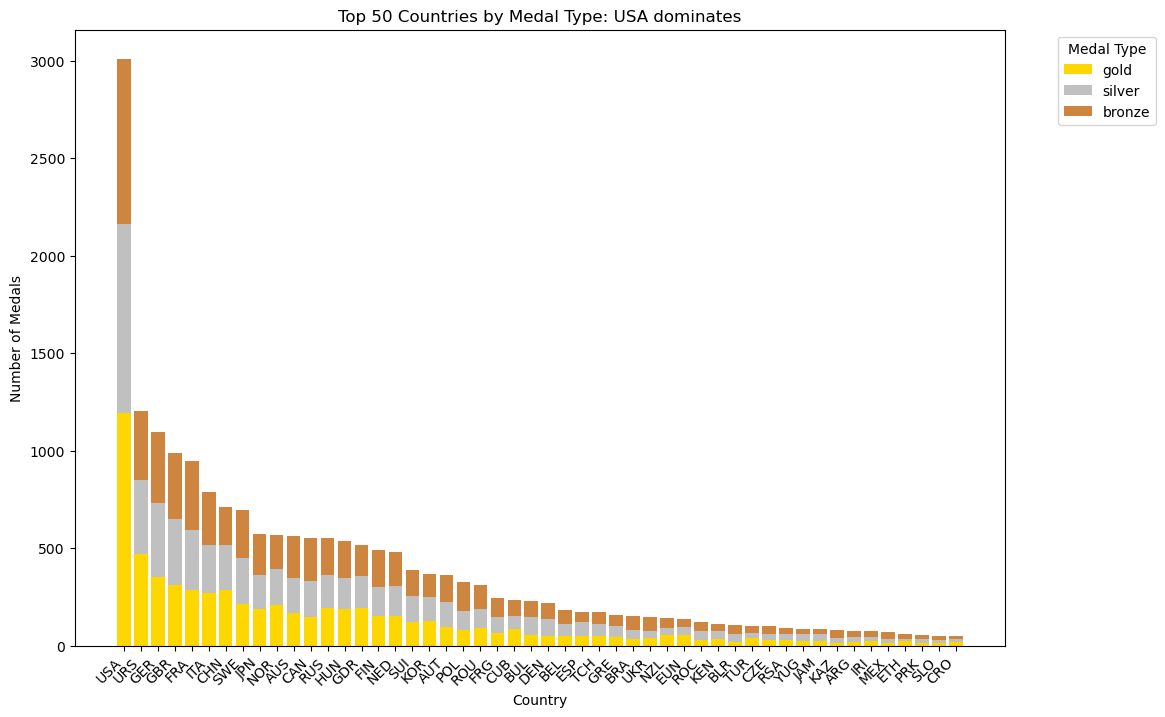

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_medals_melted is your melted dataframe

df_stacked = df_medals_melted.pivot_table(index='country_noc', columns='Medal', values='Count', fill_value=0)

df_stacked_sorted = df_stacked.sum(axis=1).sort_values(ascending=False).index
df_stacked = df_stacked.loc[df_stacked_sorted]

# Adjust colors for bronze
colors = {'gold': 'gold', 'silver': 'silver', 'bronze': 'peru'}

# Set bar width to avoid overlap
bar_width = 0.8

plt.figure(figsize=(12, 8))

bottom_values = np.zeros(len(df_stacked.index))

for medal_type, color in colors.items():
    plt.bar(df_stacked.index, df_stacked[medal_type], color=color, label=medal_type, width=bar_width, bottom=bottom_values)
    bottom_values += df_stacked[medal_type]  # Update bottom values for the next category

plt.title('Top 50 Countries by Medal Type: USA dominates')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Medal Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<strong><i> Has anything changed in the past 20 years?</i></strong>

In [110]:
#has anything changed in the past 20 years?

#filter df to include 2004 Athens games onwards

df_last20 = df_medals[['year', 'country', 'total']].copy()

df_last20 = df_last20.loc[df_last20['year'] >= 1992]
df_last20.head()

,year,country,total
694,1992,Unified Team,112
695,1992,United States,108
696,1992,Germany,82
697,1992,People's Republic of China,54
698,1992,Cuba,31


In [111]:
total_by_country = df_last20.groupby('country')['total'].sum()
top_10_countries = total_by_country.sort_values(ascending=False).head(12)
top_10_countries_list = total_by_country.sort_values(ascending=False).head(12).index.tolist()

recent_games  = df_last20[df_last20['country'].isin(top_10_countries_list)]

recent_games.head()

,year,country,total
695,1992,United States,108
696,1992,Germany,82
697,1992,People's Republic of China,54
700,1992,Republic of Korea,29
702,1992,France,29


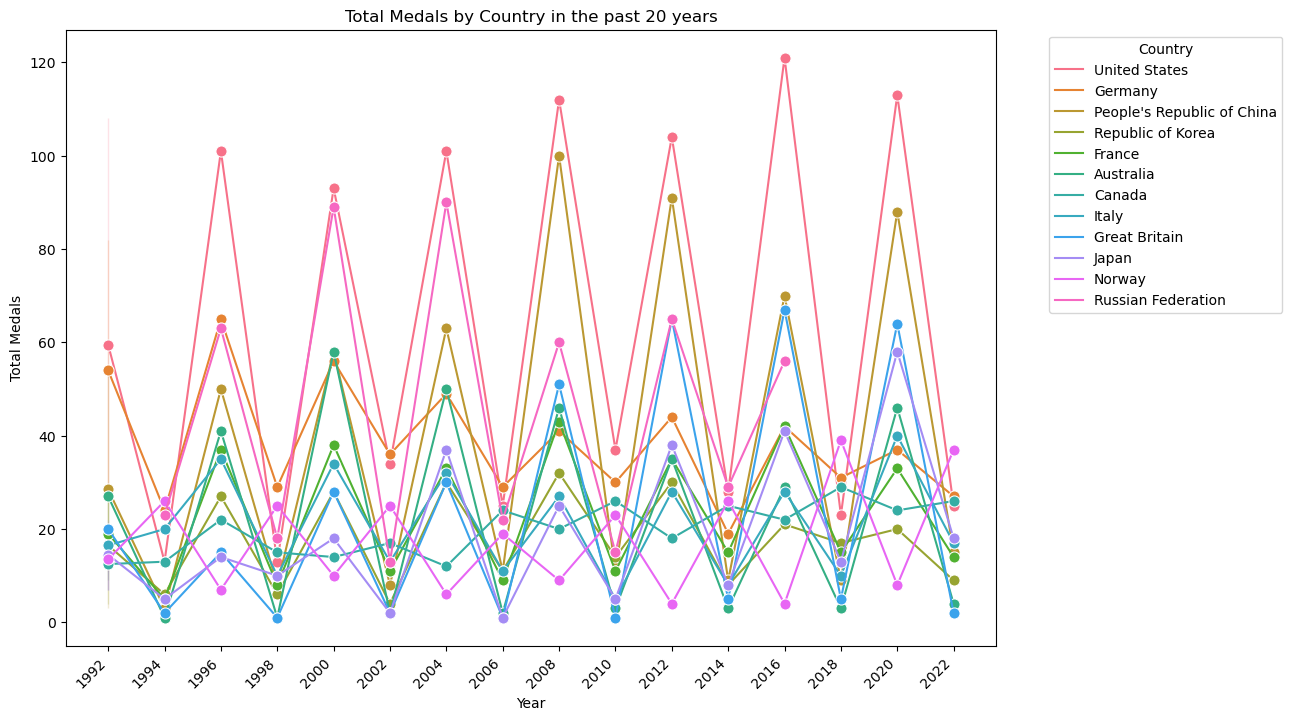

In [112]:

plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='total', hue='country', data=recent_games, marker='o', markersize=8)

plt.xticks(recent_games['year'].unique())

plt.title('Total Medals by Country in the past 20 years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.xticks(rotation=45, ha='right')  
plt.show()

In the past 30 years, USA continues to remain extremely dominant at the Summer Olympics (first Summer Olympics in the graph took place in 1992 and first Winter Olympics took place in 1994). The Russian Federation/Soviet Union which historically had the second most medals is not as dominant as before. In the past 4 editions of the Summer games, China has won the second most number of medals, bypassing Russia. Great Britain has also steadily increased their medal count in the past 30 years.
However at the Winter Olympics, Norway's athletes have been outpacing the U.S. and Germany.


<strong> <i>Do GDP and Population have an impact on the number of medals won?<i><strong>

In [113]:
#GDP and population - using the past 10 year avg as a proxy as data is available 1960 onwards for some countries,
#while data for some is available even later
df_country_gdp = pd.read_csv('data/raw/country_gdp.csv')
df_country_gdp.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.055866e+08,4.877095e+08,5.966480e+08,6.955307e+08,7.648045e+08,8.720670e+08,9.586592e+08,1.083240e+09,1.245810e+09,1.320670e+09,1.379888e+09,1.531844e+09,1.665363e+09,1.722905e+09,1.873184e+09,1.896648e+09,1.962011e+09,2.044134e+09,2.254749e+09,2.359777e+09,2.469832e+09,2.677654e+09,2.843017e+09,2.553631e+09,2.453631e+09,2.637989e+09,2.615084e+09,2.727933e+09,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.276188e+09,3.395794e+09,2.610039e+09,3.126019e+09,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,3.201437e+10,3.326951e+10,3.632779e+10,4.163897e+10,4.462989e+10,4.917337e+10,5.312346e+10,6.948272e+10,8.538065e+10,9.083543e+10,9.021275e+10,1.020000e+11,1.160000e+11,1.340000e+11,1.710000e+11,1.760000e+11,1.680000e+11,1.760000e+11,1.610000e+11,1.370000e+11,1.530000e+11,1.870000e+11,2.050000e+11,2.180000e+11,2.540000e+11,2.770000e+11,2.460000e+11,2.430000e+11,2.400000e+11,2.700000e+11,2.690000e+11,2.830000e+11,2.670000e+11,2.630000e+11,2.850000e+11,2.600000e+11,2.670000e+11,3.540000e+11,4.400000e+11,5.140000e+11,5.780000e+11,6.630000e+11,7.110000e+11,7.220000e+11,8.640000e+11,9.680000e+11,9.750000e+11,9.860000e+11,1.010000e+12,9.270000e+11,8.850000e+11,1.020000e+12,1.010000e+12,1.000000e+12,9.280000e+11,1.080000e+12,1.170000e+12
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,1.373333e+09,1.408889e+09,1.748887e+09,1.831109e+09,1.595555e+09,1.733333e+09,2.155555e+09,2.366667e+09,2.555556e+09,2.953333e+09,3.300000e+09,3.697940e+09,3.641723e+09,3.478788e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.854235e+09,4.539497e+09,5.220825e+09,6.226199e+09,6.971383e+09,9.715765e+09,1.024977e+10,1.215484e+10,1.563384e+10,1.819041e+10,2.020357e+10,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,1.591084e+10,1.451058e+10,1.496824e+10,1.697932e+10,2.359616e+10,2.093636e+10,2.538617e+10,3.197559e+10,4.441668e+10,5.166719e+10,6.235162e+10,6.559512e+10,7.149650e+10,8.894834e+10,1.120000e+11,2.110000e+11,1.870000e+11,1.380000e+11,1.150000e+11,1.170000e+11,1.080000e+11,1.110000e+11,1.090000e+11,1.020000e+11,1.220000e+11,1.180000e+11,1.190000e+11,9.927218e+10,8.663640e+10,1.090000e+11,1.260000e+11,1.280000e+11,1.310000e+11,1.380000e+11,1.410000e+11,1.490000e+11,1.770000e+11,2.050000e+11,2.540000e+11,3.110000e+11,3.970000e+11,4.650000e+11,5.680000e+11,5.080000e+11,5.990000e+11,6.820000e+11,7.380000e+11,8.340000e+11,8.940000e+11,7.690000e+11,6.910000e+11,6.850000e+11,7.670000e+11,8.230000e+11,7.860000e+11,8.440000e+11,8.780000e+11
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,5.784342e+09,6.131475e+09,7.554065e+09,7.072536e+09,8.084412e+09,8.769837e+09,1.020178e+10,1.122952e+10,1.270456e+10,1.511435e+10,1.105194e+10,3.390500e+09,5.561222e+09,7.526964e+09,7.648377e+09,6.506230e+09,6.152923e+09,9.129595e+09,8.936079e+09,1.528559e+10,1.781270e+10,2.355206e+10,3.697090e+10,5.238103e+10,6.526642e+10,8.853866e+10,7.030720e+10,8.169953e+10,1.090000e+11,1.250000e+11,

In [114]:
df_country_gdp.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)

In [115]:
df_country2 = pd.merge(df_country, df_country_gdp, how='left', left_on='country', right_on='Country Name')

exclude_columns = ['country_noc', 'country', 'Country Code', 'Country Name']
numeric_columns = df_country2.select_dtypes(include=['number']).columns

# Filter out columns to exclude from the division
columns_to_divide = numeric_columns.difference(exclude_columns)

# Perform division only on numeric columns
df_country2[columns_to_divide] = df_country2[columns_to_divide].div(1e9)

df_country2.head()


,country_noc,country,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,Afghanistan,AFG,0.537778,0.548889,0.546667,0.751111,0.800000,1.006667,1.400000,1.673333,1.373333,1.408889,1.748887,1.831109,1.595555,1.733333,2.155555,2.366667,2.555556,2.953333,3.300000,3.697940,3.641723,3.478788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.854235,4.539497,5.220825,6.226199,6.971383,9.715765,10.249770,12.154836,15.633844,18.190414,20.203573,20.564485,20.550583,19.998144,18.019554,18.896353,18.418860,18.904502,20.143452,14.583135,NaN
1,ALB,Albania,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.857338,1.897050,2.097326,2.080796,2.051236,2.253090,2.028554,1.099559,0.652175,1.185315,1.880951,2.392765,3.199641,2.258514,2.545965,3.212122,3.480355,3.922101,4.348068,5.611496,7.184686,8.052077,8.896075,10.677325,12.881353,12.044206,11.926927,12.890760,12.319834,12.776225,13.228148,11.386853,11.861200,13.019726,15.156424,15.401826,15.162734,17.930565,18.882096
2,ALG,Algeria,Algeria,DZA,2.723615,2.434747,2.001445,2.702982,2.909316,3.136284,3.039859,3.370870,3.852147,4.257253,4.863527,5.077183,6.766744,8.707858,13.209872,15.557901,17.728241,20.972112,26.364491,33.243710,42.345829,44.348587,45.207171,48.80137,53.698548,57.937869,63.692012,66.745823,59.089400,55.634719,62.048505,45.715676,48.003133,49.945585,42.543177,41.764292,46.941554,48.177612,48.187782,48.640672,54.790399,54.744698,56.760356,67.863850,85.332581,103.000000,117.000000,135.000000,171.000000,137.000000,161.000000,200.000000,209.000000,210.000000,214.000000,166.000000,160.000000,170.000000,175.000000,172.000000,146.000000,163.000000,192.000000
3,ASA,American Samoa,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512000,0.524000,0.509000,0.500000,0.493000,0.518000,0.560000,0.675000,0.573000,0.570000,0.640000,0.638000,0.643000,0.673000,0.671000,0.612000,0.639000,0.647000,0.716000,0.709000,NaN
4,AND,Andorra,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078618,0.089407,0.113414,0.150842,0.186557,0.220113,0.227284,0.253998,0.308020,0.411548,0.446378,0.388983,0.375915,0.32785,0.330073,0.346743,0.481996,0.611300,0.721426,0.795489,1.028989,1.106891,1.209993,1.007091,1.017545,1.178745,1.224023,1.180646,1.211954,1.239840,1.429048,1.546912,1.755990,2.361636,2.895048,3.159827,3.456265,3.952398,4.085782,3.674188,3.449926,3.629134,3.188653,3.193513,3.271686,2.789881,2.896610,3.000162,3.218420,3.155149,2.891001,3.325145,3.352033


In [116]:
df_country2.iloc[:, -10:] = df_country2.iloc[:, -10:].apply(pd.to_numeric, errors='coerce')

# # Calculate the mean of the last 10 columns while ignoring NaN values
df_country2['mean_gdp_last_10yr_bn'] = df_country2.iloc[:, -10:].mean(axis=1, skipna=True)

df_country2.head()

,country_noc,country,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_gdp_last_10yr_bn
0,AFG,Afghanistan,Afghanistan,AFG,0.537778,0.548889,0.546667,0.751111,0.800000,1.006667,1.400000,1.673333,1.373333,1.408889,1.748887,1.831109,1.595555,1.733333,2.155555,2.366667,2.555556,2.953333,3.300000,3.697940,3.641723,3.478788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.854235,4.539497,5.220825,6.226199,6.971383,9.715765,10.249770,12.154836,15.633844,18.190414,20.203573,20.564485,20.550583,19.998144,18.019554,18.896353,18.418860,18.904502,20.143452,14.583135,NaN,18.897674
1,ALB,Albania,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.857338,1.897050,2.097326,2.080796,2.051236,2.253090,2.028554,1.099559,0.652175,1.185315,1.880951,2.392765,3.199641,2.258514,2.545965,3.212122,3.480355,3.922101,4.348068,5.611496,7.184686,8.052077,8.896075,10.677325,12.881353,12.044206,11.926927,12.890760,12.319834,12.776225,13.228148,11.386853,11.861200,13.019726,15.156424,15.401826,15.162734,17.930565,18.882096,14.480580
2,ALG,Algeria,Algeria,DZA,2.723615,2.434747,2.001445,2.702982,2.909316,3.136284,3.039859,3.370870,3.852147,4.257253,4.863527,5.077183,6.766744,8.707858,13.209872,15.557901,17.728241,20.972112,26.364491,33.243710,42.345829,44.348587,45.207171,48.80137,53.698548,57.937869,63.692012,66.745823,59.089400,55.634719,62.048505,45.715676,48.003133,49.945585,42.543177,41.764292,46.941554,48.177612,48.187782,48.640672,54.790399,54.744698,56.760356,67.863850,85.332581,103.000000,117.000000,135.000000,171.000000,137.000000,161.000000,200.000000,209.000000,210.000000,214.000000,166.000000,160.000000,170.000000,175.000000,172.000000,146.000000,163.000000,192.000000,176.800000
3,ASA,American Samoa,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512000,0.524000,0.509000,0.500000,0.493000,0.518000,0.560000,0.675000,0.573000,0.570000,0.640000,0.638000,0.643000,0.673000,0.671000,0.612000,0.639000,0.647000,0.716000,0.709000,NaN,0.660889
4,AND,Andorra,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078618,0.089407,0.113414,0.150842,0.186557,0.220113,0.227284,0.253998,0.308020,0.411548,0.446378,0.388983,0.375915,0.32785,0.330073,0.346743,0.481996,0.611300,0.721426,0.795489,1.028989,1.106891,1.209993,1.007091,1.017545,1.178745,1.224023,1.180646,1.211954,1.239840,1.429048,1.546912,1.755990,2.361636,2.895048,3.159827,3.456265,3.952398,4.085782,3.674188,3.449926,3.629134,3.188653,3.193513,3.271686,2.789881,2.896610,3.000162,3.218420,3.155149,2.891001,3.325145,3.352033,3.109360


In [117]:
missing_values_gdp = df_country2['mean_gdp_last_10yr_bn'].isnull().sum()
missing_values_gdp

53

We would like to use GDP and Population  as additional independent variables in our models and examine whether it has an impact on the medals tally or not. One of the limitations we are facing with the World Bank data is that it is available only 1960 onwards with data for some countries being available much later. The data for the past 10 years is available and we plan on using the 10yr mean as a proxy for GDP in our model. An alternative way is to create dummy variables after categorizing the countries based on the range of their population, eg- high, medium, low. The chart below shows the countries with the highest mean GDP over the past 10 years and  we guess that GDP  is positively correlated with the medals count.  

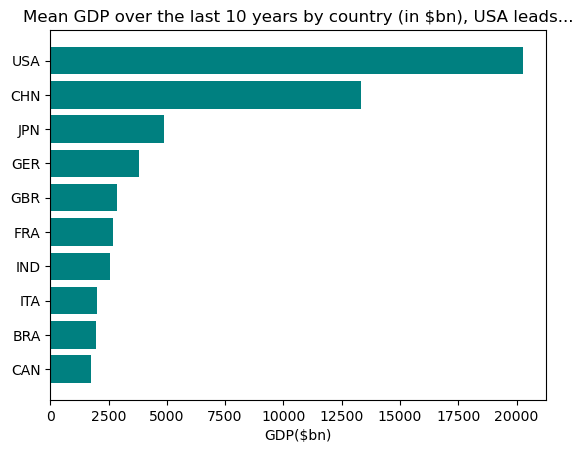

In [118]:
df_sorted = df_country2.sort_values(by='mean_gdp_last_10yr_bn', ascending=False)
top_10_values = df_sorted.head(10)

plt.barh(top_10_values['country_noc'], top_10_values['mean_gdp_last_10yr_bn'], color='teal')
plt.xlabel('GDP($bn)')
plt.title('Mean GDP over the last 10 years by country (in $bn), USA leads...')
plt.gca().invert_yaxis()
plt.show()

In [119]:
df_pop = pd.read_csv('data/raw/country_population.csv')
df_pop.drop(['Country Name',  'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_pop.head()

,Country_Updated,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,59471.0,59330.0,59106.0,58816.0,58855.0,59365.0,60028.0,60715.0,61193.0,61465.0,61738.0,62006.0,62267.0,62614.0,63116.0,63683.0,64174.0,64478.0,64553.0,64450.0,64332.0,64596.0,65712.0,67864.0,70192.0,72360.0,74710.0,77050.0,79417.0,81858.0,84355.0,86867.0,89101.0,90691.0,91781.0,92701.0,93540.0,94483.0,95606.0,96787.0,97996.0,99212.0,100341.0,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0
1,Africa Eastern and Southern,AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,162875171.0,167596160.0,172475766.0,177503186.0,182599092.0,187901657.0,193512956.0,199284304.0,205202669.0,211120911.0,217481420.0,224315978.0,230967858.0,237937461.0,245386717.0,252779730.0,260209149.0,267938123.0,276035920.0,284490394.0,292795186.0,301124880.0,309890664.0,318544083.0,326933522.0,335625136.0,344418362.0,353466601.0,362985802.0,372352230.0,381715600.0,391486231.0,401600588.0,412001885.0,422741118.0,433807484.0,445281555.0,457153837.0,469508516.0,482406426.0,495748900.0,509410477.0,523459657.0,537792950.0,552530654.0,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720839314.0
2,Afghanistan,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,10247780.0,10494489.0,10752971.0,11015857.0,11286753.0,11575305.0,11869879.0,12157386.0,12425267.0,12687301.0,12938862.0,12986369.0,12486631.0,11155195.0,10088289.0,9951449.0,10243686.0,10512221.0,10448442.0,10322758.0,10383460.0,10673168.0,10694796.0,10745167.0,12057433.0,14003760.0,15455555.0,16418912.0,17106595.0,17788819.0,18493132.0,19262847.0,19542982.0,19688632.0,21000256.0,22645130.0,23553551.0,24411191.0,25442944.0,25903301.0,26427199.0,27385307.0,28189672.0,29249157.0,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
3,Africa Western and Central,AFW,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,115921723.0,118615741.0,121424797.0,124336039.0,127364044.0,130563107.0,133953892.0,137548613.0,141258400.0,145122851.0,149206663.0,153459665.0,157825609.0,162323313.0,167023385.0,171566640.0,176054495.0,180817312.0,185720244.0,190759952.0,195969722.0,201392200.0,206739024.0,212172888.0,217966101.0,223788766.0,229675775.0,235861484.0,242200260.0,248713095.0,255482918.0,262397030.0,269611898.0,277160097.0,284952322.0,292977949.0,301265247.0,309824829.0,318601484.0,327612838.0,336893835.0,346475221.0,356337762.0,366489204.0,376797999.0,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0
4,Angola,AGO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,5868203.0,5928386.0,6029700.0,6177049.0,6364731.0,6578230.0,6802494.0,7032713.0,7266780.0,7511895.0,7771590.0,8043218.0,8330047.0,8631457.0,8947152.0,9276707.0,9617702.0,9970621.0,10332574.0,10694057.0,11060261.0,11439498.0,11828638.0,12228691.0,12632507.0,13038270.0,13462031.0,13912253.0,14383350.0,14871146.0,15366864.0,15870753.0,16394062.0,16941587.0,17516139.0,18124342.0,18771125.0,19450959.0,20162340.0,20909684.0,21691522.0,22507674.0,23364185.0,24259111.0,25188292.0,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0


In [120]:
#df_pop.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_pop2 = pd.merge(df_country, df_pop, how='left', left_on='country', right_on='Country_Updated')
df_pop2.head(3)

,country_noc,country,Country_Updated,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,Afghanistan,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,10247780.0,10494489.0,10752971.0,11015857.0,11286753.0,11575305.0,11869879.0,12157386.0,12425267.0,12687301.0,12938862.0,12986369.0,12486631.0,11155195.0,10088289.0,9951449.0,10243686.0,10512221.0,10448442.0,10322758.0,10383460.0,10673168.0,10694796.0,10745167.0,12057433.0,14003760.0,15455555.0,16418912.0,17106595.0,17788819.0,18493132.0,19262847.0,19542982.0,19688632.0,21000256.0,22645130.0,23553551.0,24411191.0,25442944.0,25903301.0,26427199.0,27385307.0,28189672.0,29249157.0,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
1,ALB,Albania,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,2022272.0,2081695.0,2135479.0,2187853.0,2243126.0,2296752.0,2350124.0,2404831.0,2458526.0,2513546.0,2566266.0,2617832.0,2671997.0,2726056.0,2784278.0,2843960.0,2904429.0,2964762.0,3022635.0,3083605.0,3142336.0,3227943.0,3286542.0,3266790.0,3247039.0,3227287.0,3207536.0,3187784.0,3168033.0,3148281.0,3128530.0,3108778.0,3089027.0,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0,2775634.0
2,ALG,Algeria,Algeria,DZA,11394307.0,11598608.0,11778260.0,11969451.0,12179099.0,12381256.0,12613389.0,12897115.0,13190975.0,13491016.0,13795915.0,14110271.0,14439748.0,14786469.0,15153602.0,15724692.0,16500516.0,17134192.0,17632645.0,18166981.0,18739378.0,19351357.0,20000096.0,20682111.0,21393530.0,22132905.0,22882553.0,23586101.0,24243018.0,24889507.0,25518074.0,26133905.0,26748303.0,27354327.0,27937006.0,28478022.0,28984634.0,29476031.0,29924668.0,30346083.0,30774621.0,31200985.0,31624696.0,32055883.0,32510186.0,32956690.0,33435080.0,33983827.0,34569592.0,35196037.0,35856344.0,36543541.0,37260563.0,38000626.0,38760168.0,39543154.0,40339329.0,41136546.0,41927007.0,42705368.0,43451666.0,44177969.0,44903225.0


In [121]:
exclude_columns = ['country_noc', 'country', 'Country Code', 'Country_Updated']
df_pop2.loc[:, df_pop2.columns.difference(exclude_columns)] /= 1e6 # convert to millions 

In [122]:
#following a similar approach of taking the 10 year mean
df_pop2['mean_pop_last_10yr_mm'] = df_pop2.iloc[:, -10:].mean(axis=1)
df_country_pop = df_pop2[['country_noc', 'country', 'Country Code', 'mean_pop_last_10yr_mm']].copy()
#df_country_pop.to_clipboard(index=False)

In [123]:
missing_values_pop = df_country_pop['mean_pop_last_10yr_mm'].isnull().sum()
missing_values_pop

51

We followed a similar approach for Population and calculated the 10yr mean as a proxy. Apart from China, USA, Russia, Japan, other countries with the highest mean population generally do not do well at the Games. Having a larger population could also mean less resources to invest in training athletes and could in fact, have a negative impact on medals won.

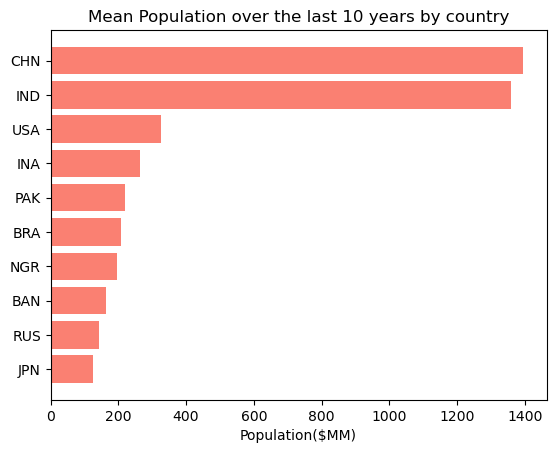

In [124]:
df_sorted_pop = df_country_pop.sort_values(by='mean_pop_last_10yr_mm', ascending=False)
top_10_values_pop = df_sorted_pop.head(10)


plt.barh(top_10_values_pop['country_noc'], top_10_values_pop['mean_pop_last_10yr_mm'], color='salmon')
plt.xlabel('Population($MM)')
plt.title('Mean Population over the last 10 years by country')
plt.gca().invert_yaxis()
plt.show()

In [125]:
#group by total medals for each country

df_grouped = df_medals.groupby('country_noc')['total'].sum()
df_grouped = pd.DataFrame(df_grouped)
df_grouped.reset_index(inplace=True)

In [126]:
#check correlation between variables and medals tally

df_merged = pd.merge(df_grouped, df_country2[['country_noc','mean_gdp_last_10yr_bn']
                                                                        ],how='left', on='country_noc')

df_merged2 = pd.merge(df_merged, df_country_pop[['country_noc','mean_pop_last_10yr_mm']
                                                                        ],how='left', on='country_noc')


df_merged2.head()


,country_noc,total,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm
0,AFG,2,18.897674,36.294729
1,AHO,1,NaN,NaN
2,ALG,17,176.800000,41.494506
3,ANZ,12,NaN,NaN
4,ARG,77,535.400000,44.249313


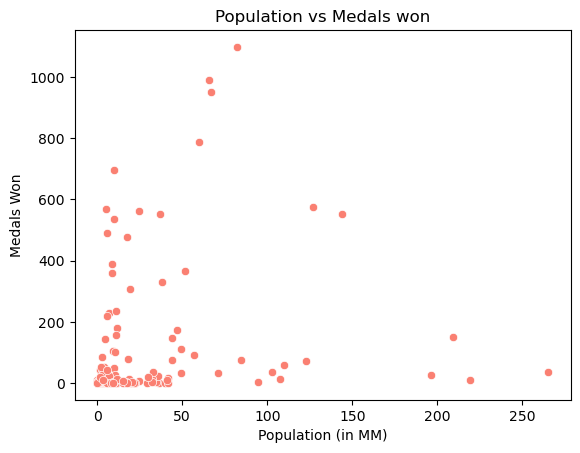

In [127]:
#exclude China, India, USA
excluded_countries = ['CHN', 'IND', 'USA']
df_filtered = df_merged2[~df_merged2['country_noc'].isin(excluded_countries)]
sns.scatterplot(y='total', x='mean_pop_last_10yr_mm', data=df_filtered, color='salmon')

# Add labels and title
plt.xlabel('Population (in MM)')
plt.ylabel('Medals Won')
plt.title('Population vs Medals won')

# Show the plot
plt.show()

We excluded China and USA along with India which has the second highest 10 yr mean population and it appears that some countries with smaller populations have won more medals. However, there are also countries that are very tiny, have very small populations and hence, have very low participation at the Olympics.

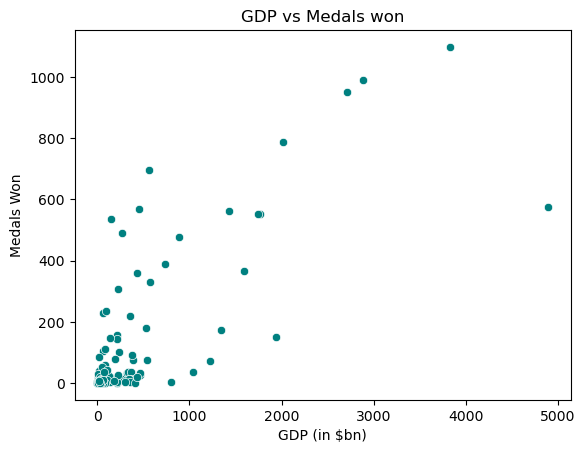

In [128]:
sns.scatterplot(y='total', x='mean_gdp_last_10yr_bn', data=df_filtered, color='teal')

# Add labels and title
plt.xlabel('GDP (in $bn)')
plt.ylabel('Medals Won')
plt.title('GDP vs Medals won')

# Show the plot
plt.show()

The scatter plot confirms that GDP is positvely correlated with medals one. We still have countries with missing GDP but they are either very small or nations that had a name change, we will be excluding those records.

In [129]:
# excluded_countries = ['USA']
# df_filtered = df_merged3[~df_merged3['country_noc'].isin(excluded_countries)]

# sns.scatterplot(y='total', x='total_athletes', data=df_filtered, color='mediumpurple')


# # Add labels and title
# plt.xlabel('Contingent Size')
# plt.ylabel('Medals Won')
# plt.title('Contingent Size vs Medals won')

# # Show the plot
# plt.show()

In [131]:
# join athletes with events to get the sport for each athlete, it is not in df_athletes

df_athletes_sport = pd.merge(df_athletes[['name', 'sex', 'height', 'weight']],
                              df_event_results[['athlete', 'sport']], left_on='name', right_on='athlete', how='left')

df_athletes_sport.head()

,name,sex,height,weight,athlete,sport
0,Károly Teppert,Male,na,na,Károly Teppert,Cycling Road
1,Károly Teppert,Male,na,na,Károly Teppert,Cycling Road
2,Andrzej Socharski,Male,173.0,72,Andrzej Socharski,Shooting
3,Nathalie Wunderlich,Female,170.0,50,Nathalie Wunderlich,Swimming
4,Nathalie Wunderlich,Female,170.0,50,Nathalie Wunderlich,Swimming


In [132]:
df_athletes_sport = df_athletes_sport.dropna()

In [133]:
df_athletes_sport['height'] = pd.to_numeric(df_athletes_sport['height'], errors='coerce')  
df_athletes_sport['weight'] = pd.to_numeric(df_athletes_sport['weight'], errors='coerce')  

# Group by 'sport' and calculate the average height and weight
average_data = df_athletes_sport.groupby(['sport', 'sex'])[['height', 'weight']].mean().reset_index()

#select a few sports 

select_sports = ['Archery', 'Artistic Gymnastics', 'Athletics',
                'Badminton', 'Boxing', 'Cross Country Skiing',
                'Cycling Track', 'Diving', 'Equestrian Dressage',
                'Fencing', 'Hockey', 'Judo',
                 'Rowing', 'Shooting', 'Handball',
                 'Swimming', 'Triathlon', 'Volleyball',
                 'Weightlifting', 'Wrestling', 'Basketball', 'Table Tennis', 'Tennis'
                ]

#keep only selected sports
mask = average_data['sport'].isin(select_sports) 
selected_df = average_data[mask]

<strong><i>How does an athlete’s height and weight affect their choice of sport?<strong><i>

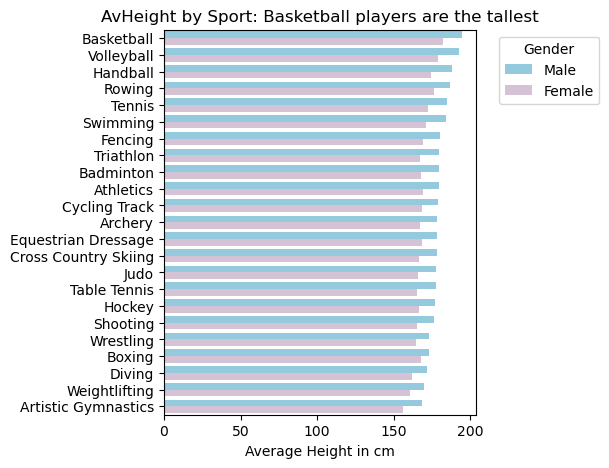

In [134]:
# Sort  in descending order
average_height_by_sport = selected_df.sort_values(by='height', ascending=False)
average_height_by_sport.dropna(inplace=True)

colors = {'Female': 'thistle', 'Male': 'skyblue'}

plt.figure(figsize=(5, 5))
sns.barplot(y='sport', x='height', hue='sex', data=average_height_by_sport, palette=colors)
plt.title('AvHeight by Sport: Basketball players are the tallest')
plt.xlabel('Average Height in cm')
plt.ylabel('')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.75)
plt.show()

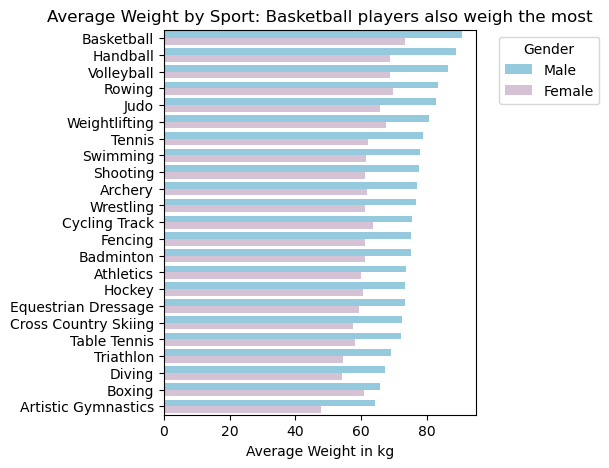

In [135]:
# Sort weight in descending order
average_weight_by_sport = selected_df.sort_values(by='weight', ascending=False)
average_weight_by_sport.dropna(inplace=True)

colors = {'Female': 'thistle', 'Male': 'skyblue'}

plt.figure(figsize=(5, 5))
sns.barplot(y='sport', x='weight', hue='sex', data=average_weight_by_sport, palette=colors)
plt.title('Average Weight by Sport: Basketball players also weigh the most')
plt.xlabel('Average Weight in kg')
plt.ylabel('')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.75)
plt.show()

We selected some of the most popular events at the Olympics to see if there is any obvious trend in the height and weight of athletes competing in those sports. The charts above show the average height and weight of all the athletes playing a particular sport, missing records were excluded. Basketball players tend to be the tallest and also weigh the most but the difference in the average height across sports is minimal for both males and females. On the other hand, the difference in weight between males and females across the different sports is more obvious. Furthermore, gymnasts, boxers and divers weigh less than athletes playing basketball or handball.

<strong><i>Which countries do better at team vs individual events?</i></strong>

In [136]:
#which countries do better at team vs individual events

df_event_results2 = df_event_results[df_event_results['medal'] != 'na']
df_event_results2.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport
20,1908 Summer Olympics,5,ANZ,Athletics,"3,500 metres Race Walk, Men",56421,Harry Kerr,64719,3,Bronze,False
30,1908 Summer Olympics,5,ANZ,Boxing,"Middleweight, Men",21263,Snowy Baker,45153,2,Silver,False
32,1908 Summer Olympics,5,ANZ,Rugby,"Rugby, Men",31505,John Barnett,11237,1,Gold,True
33,1908 Summer Olympics,5,ANZ,Rugby,"Rugby, Men",31505,Phil Carmichael,11239,1,Gold,True
34,1908 Summer Olympics,5,ANZ,Rugby,"Rugby, Men",31505,Dan Carroll,11240,1,Gold,True


In [137]:
#group by country

df_team = df_event_results2.groupby(['country_noc', 'isTeamSport']).result_id.count().reset_index()
df_team = pd.DataFrame(df_team)


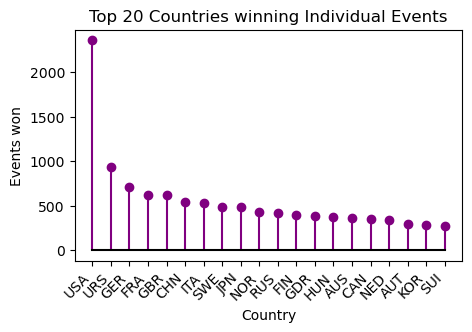

In [138]:
#filter by team vs individual
filtered_data = df_team[df_team['isTeamSport'] == False]

top_20_countries = filtered_data.groupby('country_noc')['result_id'].sum().nlargest(20).index

top_20_data = filtered_data[filtered_data['country_noc'].isin(top_20_countries)]

top_20_data = top_20_data.sort_values(by='result_id', ascending=False)

#lollipop chart
plt.figure(figsize=(5, 3))
plt.stem(top_20_data['country_noc'], top_20_data['result_id'], basefmt='k-', use_line_collection=True, markerfmt='purple',
         linefmt='purple')
plt.title('Top 20 Countries winning Individual Events')
plt.xlabel('Country')
plt.ylabel('Events won')
plt.xticks(rotation=45, ha='right')


plt.show()

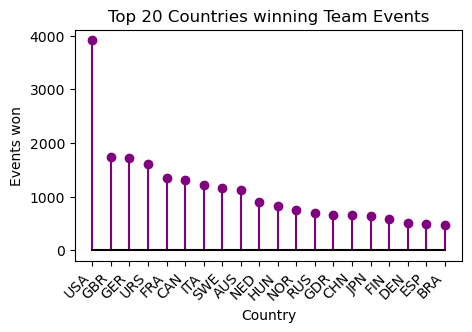

In [139]:
filtered_data2 = df_team[df_team['isTeamSport'] == True]

top_20_countries2 = filtered_data2.groupby('country_noc')['result_id'].sum().nlargest(20).index


top_20_data2 = filtered_data2[filtered_data2['country_noc'].isin(top_20_countries2)]

# Sort the data for better visualization
top_20_data2 = top_20_data2.sort_values(by='result_id', ascending=False)

# Create a lollipop chart
plt.figure(figsize=(5,3))
plt.stem(top_20_data2['country_noc'], top_20_data2['result_id'], basefmt='k-', use_line_collection=True, markerfmt='purple',
         linefmt='purple')
plt.title('Top 20 Countries winning Team Events')
plt.xlabel('Country')
plt.ylabel('Events won')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

While the USA is an outlier doing well at both individual and team events, Great Britain comes next in terms of most medals won at team events. Countries like Canada, Australia, the Netherlands among others also happen to do better at team events than individual events.

<strong><i>Who is the greatest Olympian of all time?<strong><i>

In [140]:
#greatest Olympian of all time 

greatest_olympian = df_event_results2.groupby(['athlete', 'sport', 'country_noc']).result_id.count().sort_values(ascending=False)
greatest_olympian = pd.DataFrame(greatest_olympian)
greatest_olympian.rename({'result_id':'medals_won'}, axis=1, inplace=True)
greatest_olympian.reset_index(inplace=True)
greatest_olympian.head()

,athlete,sport,country_noc,medals_won
0,Michael Phelps,Swimming,USA,28
1,Larisa Latynina,Artistic Gymnastics,URS,18
2,Marit Bjørgen,Cross Country Skiing,NOR,15
3,Nikolay Andrianov,Artistic Gymnastics,URS,15
4,Ireen Wüst,Speed Skating,NED,13


In [141]:
greatest_olympian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32361 entries, 0 to 32360
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   athlete      32361 non-null  object
 1   sport        32361 non-null  object
 2   country_noc  32361 non-null  object
 3   medals_won   32361 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1011.4+ KB


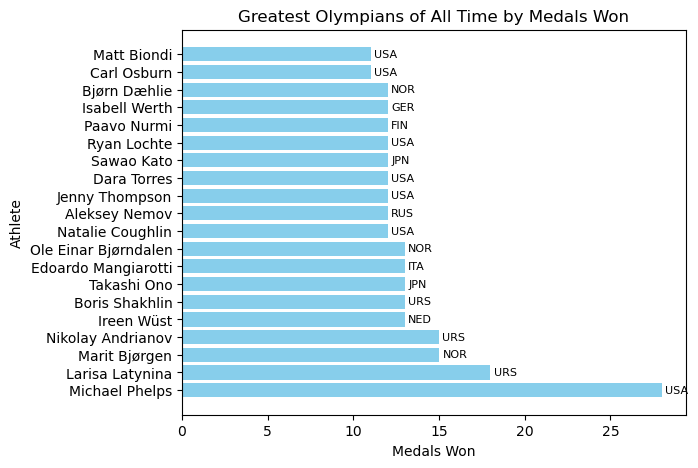

In [154]:
greatest_olympian2 = greatest_olympian.sort_values(by='medals_won', ascending=False)  # Keep ascending as False
greatest_olympian2 = greatest_olympian2.head(20)

plt.figure(figsize=(6.5, 5))
bars = plt.barh(greatest_olympian2['athlete'], greatest_olympian2['medals_won'], color='skyblue')
plt.xlabel('Medals Won')
plt.ylabel('Athlete')
plt.title('Greatest Olympians of All Time by Medals Won')

for bar, label in zip(bars, greatest_olympian2['country_noc']):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2, label, ha='left', va='center', color='black', fontsize=8)

plt.show()

Michael Phelps is well-known as the greatest Olympian of all time but in second place is Larisa Latynina, a gymnast from the former Soviet Union who won 18 medals. 25% of the top 20 are from the USA.

<strong><i>Which gender wins more medals? </strong></i>

In [538]:
#which gender wins more medals
gender_medals = pd.merge(df_athletes[['name', 'sex']], df_event_results2[['athlete','medal', 'sport','result_id']],
                        left_on="name", right_on="athlete")
gender_medals2 = gender_medals.groupby('sex').athlete.count()
gender_medals2=pd.DataFrame(gender_medals2)
gender_medals2.reset_index(inplace=True)

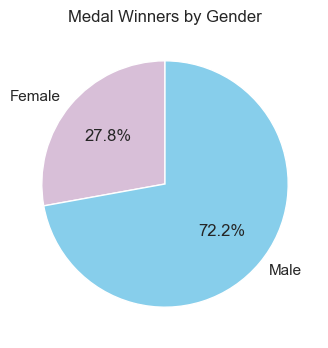

In [539]:
plt.figure(figsize=(4, 4))
sns.set(style="whitegrid")
plt.pie(gender_medals2['athlete'], labels=gender_medals2.sex, autopct='%1.1f%%', startangle=90,
        colors=['thistle', 'skyblue'])


plt.title('Medal Winners by Gender')

plt.show()


In [540]:
#gold medal winners

gender_gold = gender_medals[gender_medals['medal'] == 'Gold']

gender_gold2 = gender_gold.groupby('sex').athlete.count()
gender_gold2=pd.DataFrame(gender_gold2)
gender_gold2.reset_index(inplace=True)
gender_gold2

,sex,athlete
0,Female,4248
1,Male,11253


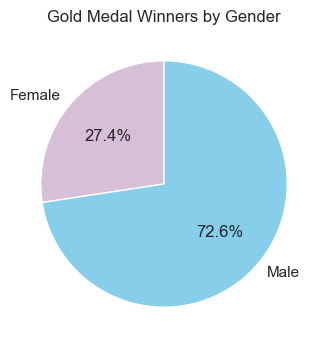

In [541]:
plt.figure(figsize=(4, 4))
sns.set(style="whitegrid")
plt.pie(gender_gold2['athlete'], labels=gender_gold2.sex, autopct='%1.1f%%', startangle=90,
        colors=['thistle', 'skyblue'])


plt.title('Gold Medal Winners by Gender')

plt.show()


72% of all medal winners are Male, with a similar stat for gold medal winners. This is expected given that the historical participation rate of female athletes  is 26%.

In [542]:
gender_all = df_athletes.groupby('sex')['name'].count()
gender_all

sex
Female     40276
Male      114755
Name: name, dtype: int64

In [543]:
# how many athletes take part by country
df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].count().head()

,edition,country_noc,athlete
0,1896 Summer Olympics,AUS,7
1,1896 Summer Olympics,AUT,10
2,1896 Summer Olympics,BUL,4
3,1896 Summer Olympics,DEN,25
4,1896 Summer Olympics,FRA,51


In [544]:
# one athlete can take part in several events
df_event_results.groupby(['edition', 'country_noc'])['athlete'].unique().reset_index(name='unique_athletes').assign(athlete_count=lambda x: x['unique_athletes'].apply(len)).head()


,edition,country_noc,unique_athletes,athlete_count
0,1896 Summer Olympics,AUS,"[Teddy Flack, George Stuart Robertson]",2
1,1896 Summer Olympics,AUT,"[Adolf Schmal, Otto Herschmann, Paul Neumann]",3
2,1896 Summer Olympics,BUL,[Charles Champaud],1
3,1896 Summer Olympics,DEN,"[Viggo Jensen, Eugen Schmidt, Holger Nielsen, ...",4
4,1896 Summer Olympics,FRA,"[Adolphe Grisel, Jean Tournois, Louis Adler, A...",18


Merge: Join medals and games

In [157]:
# df_medals['edition_id'].nunique()
# df_games['edition_id'].nunique()


# drop war and future events
df_games = df_games.drop(df_games[~df_games['edition_id'].isin(df_medals['edition_id'])].index)


df_games_medals = pd.merge(df_medals, pd.merge(df_games, df_country, on='country_noc', how='left'), on=['edition_id', 'edition', 'year'], how='left',
        suffixes=('_performing', '_host'))
df_games_medals.head()

,edition,edition_id,year,country_performing,country_noc_performing,gold,silver,bronze,total,edition_url,city,country_flag_url,country_noc_host,start_date,end_date,competition_date,isHeld,country_host
0,1896 Summer Olympics,1,1896,United States,USA,11,7,2,20,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
1,1896 Summer Olympics,1,1896,Greece,GRE,10,18,19,47,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
2,1896 Summer Olympics,1,1896,Germany,GER,6,5,2,13,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
3,1896 Summer Olympics,1,1896,France,FRA,5,4,2,11,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece
4,1896 Summer Olympics,1,1896,Great Britain,GBR,2,3,2,7,/editions/1,Athina,/images/flags/GRE.png,GRE,6 April,15 April,6 – 13 April,NaN,Greece


In [158]:
#special or one time events
df_games_medals[(df_games_medals['edition_id'] == 4)|(df_games_medals['edition_id'] == 48)]

# drop the one-time events
df_games_medals = df_games_medals.drop(df_games_medals[(df_games_medals['edition_id'] == 4)|
                                                       (df_games_medals['edition_id'] == 48)].index)

In [159]:
df_games_medals.describe()

,edition_id,year,gold,silver,bronze,total
count,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000
mean,31.850168,1980.582492,3.743547,3.727834,3.981481,11.452862
std,18.362667,32.065060,7.587106,6.441069,6.194507,19.511691
min,1.000000,1896.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,1960.000000,0.000000,1.000000,1.000000,2.000000
50%,25.000000,1988.000000,1.000000,2.000000,2.000000,5.000000
75%,53.000000,2008.000000,4.000000,4.000000,5.000000,13.000000
max,62.000000,2022.000000,83.000000,85.000000,83.000000,248.000000


In [160]:
#some more eda

def eda_visualization(df):
    numerical_columns = df.select_dtypes(include='number').columns
    categorical_columns = df.select_dtypes(exclude='number').columns

    for column in numerical_columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
        
        plt.subplot(1, 2, 2)
        ax = sns.boxplot(data=df, x=column, showfliers=False)
        plt.title(f'Boxplot of {column} Without Outliers')
        
        def add_quartile_labels(ax):
            for line in ax.lines:
                x, y = line.get_xydata()[0]  
                ax.text(x, y, f"{x:.0f}", ha='left', va='center')
        
        add_quartile_labels(ax)

        plt.tight_layout()
        plt.show()

    for column in categorical_columns:
        plt.figure(figsize=(8, 4))
        categories_to_show = df[column].value_counts().index[:30]

        if not categories_to_show.empty:
            sns.countplot(data=df[df[column].isin(categories_to_show)], x=column, order=categories_to_show)

            for idx, count in enumerate(df[df[column].isin(categories_to_show)][column].value_counts()):
                plt.text(idx, count + 1, str(count), ha='center', va='bottom', fontsize=8)

            plt.title(f'Count of each category in {column}')
            plt.xticks(rotation=90, ha='right', fontsize=7)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No categories to show for column {column}.")

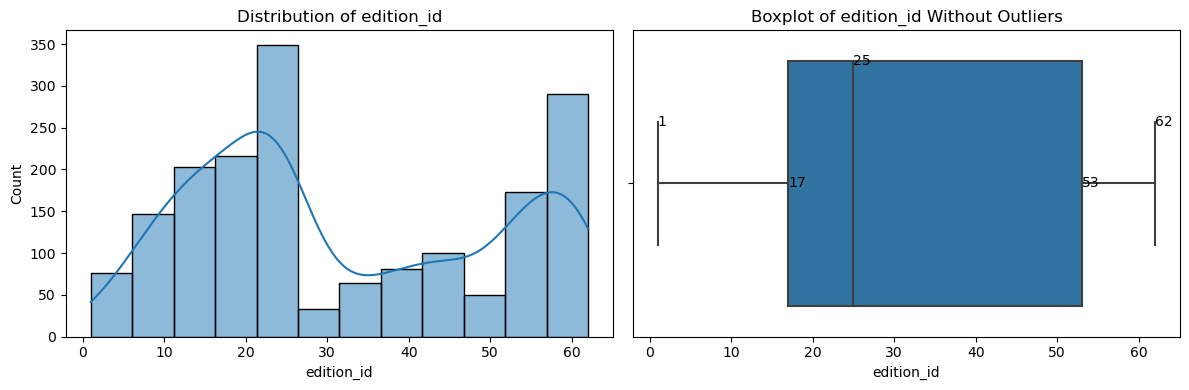

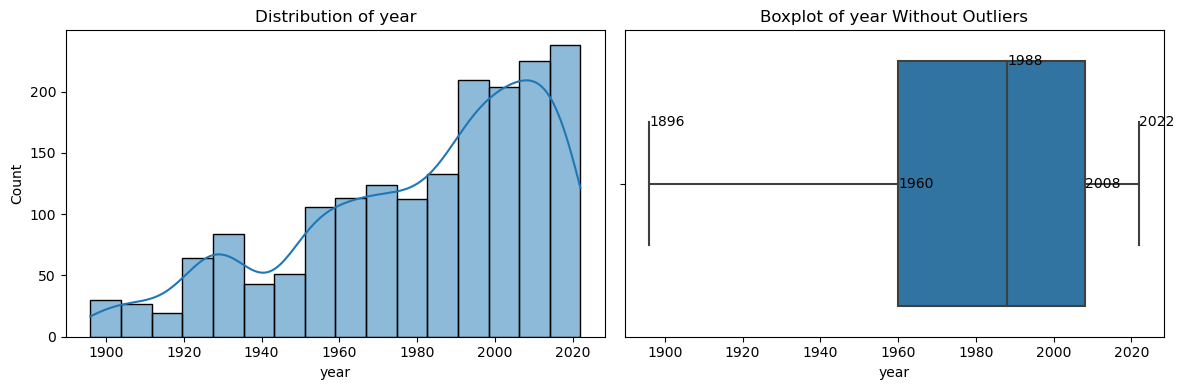

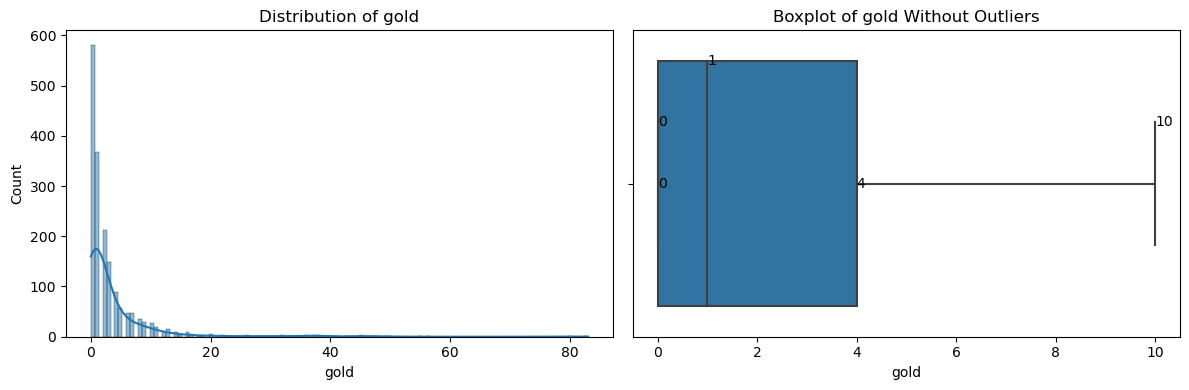

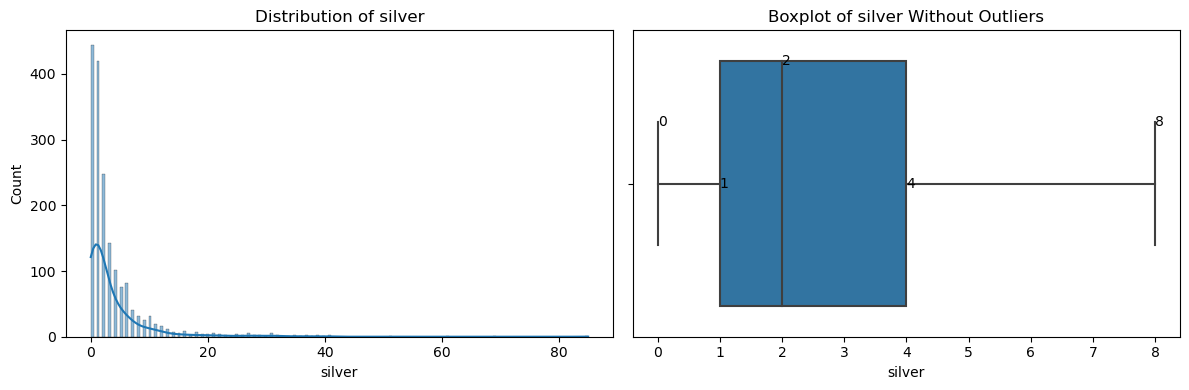

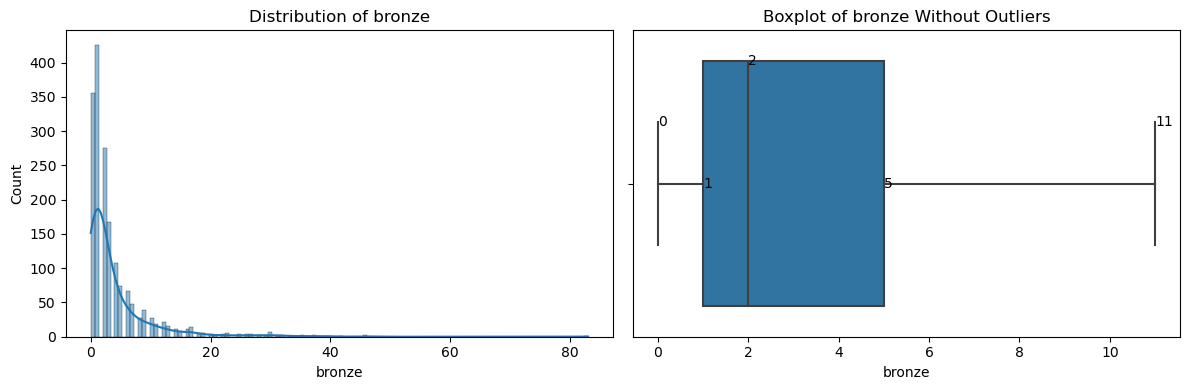

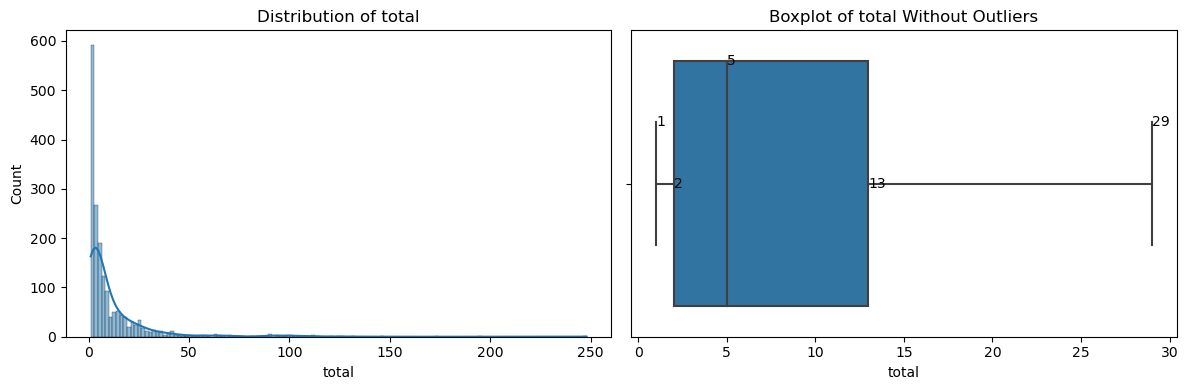

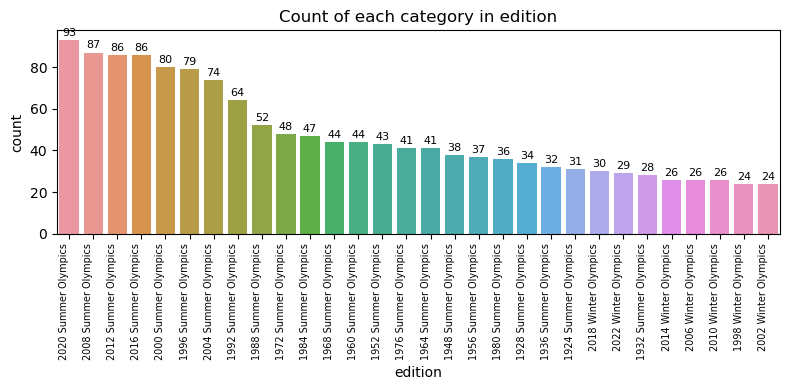

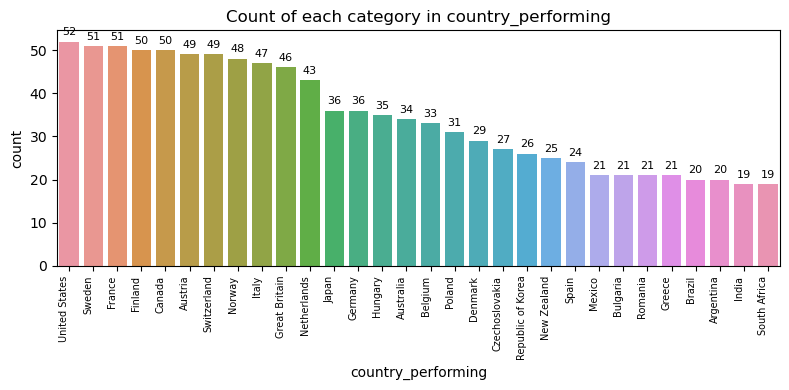

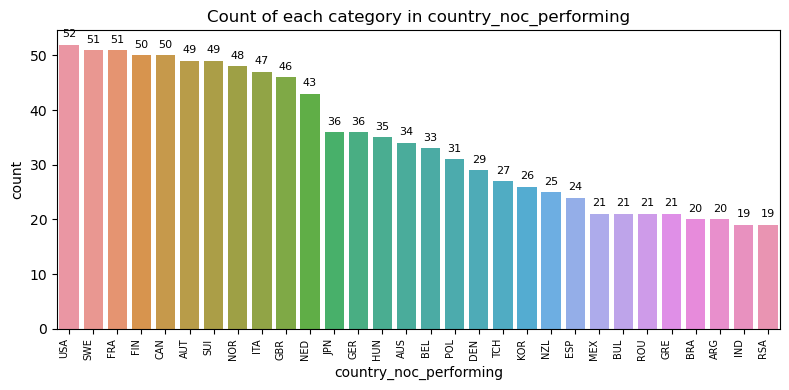

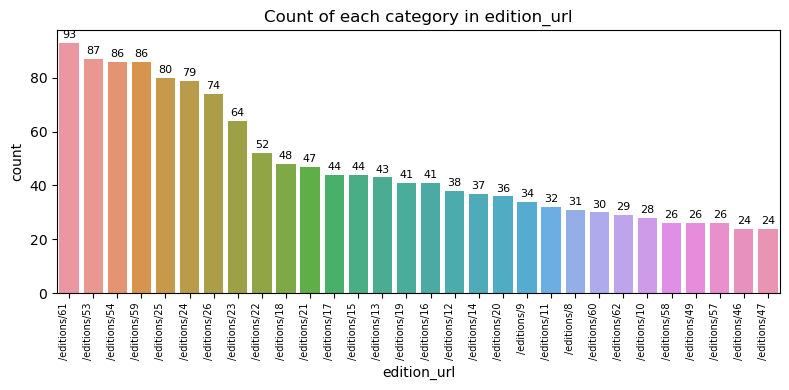

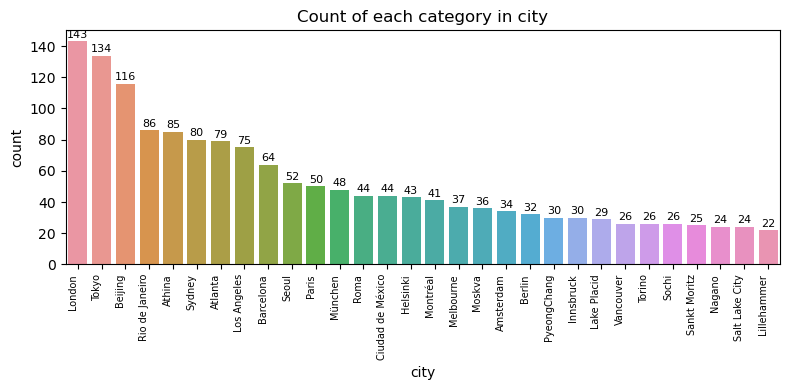

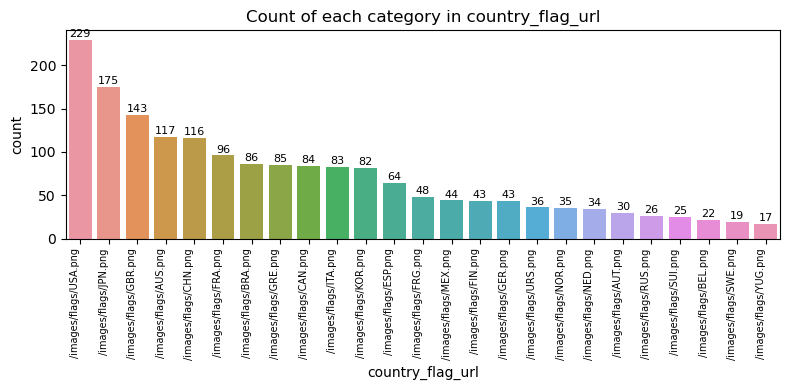

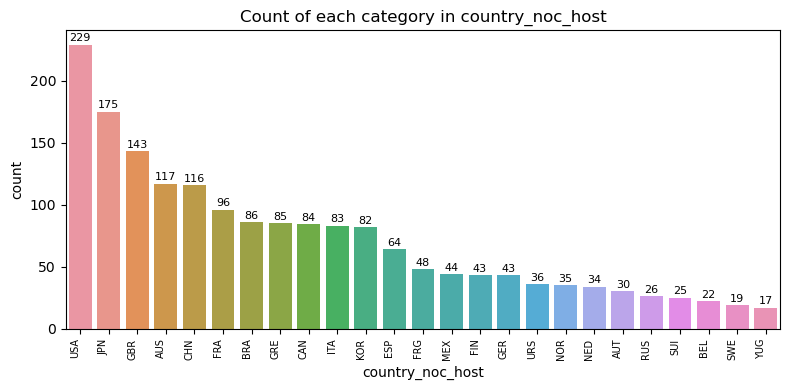

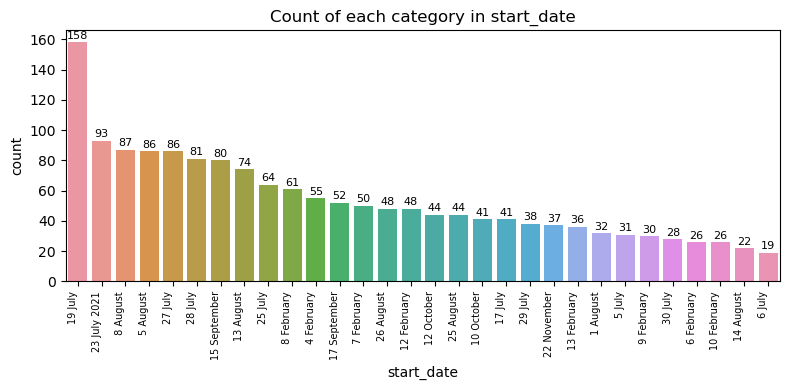

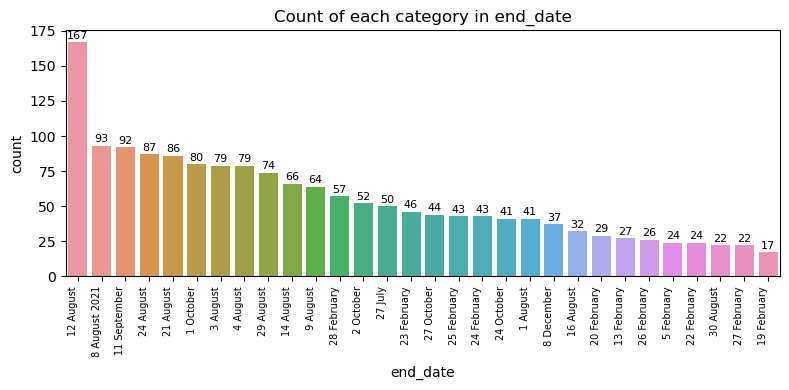

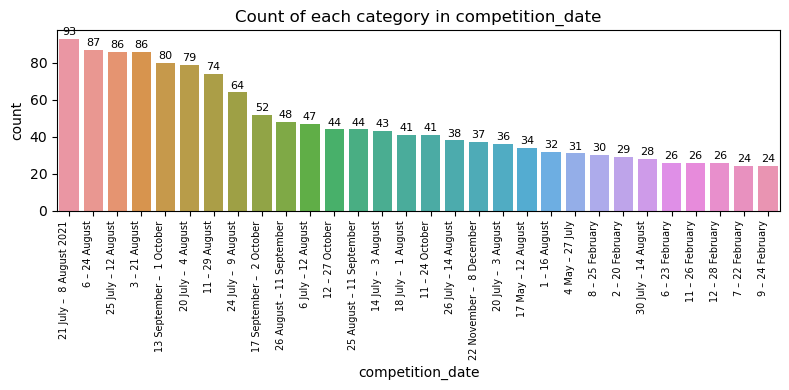

No categories to show for column isHeld.


<Figure size 800x400 with 0 Axes>

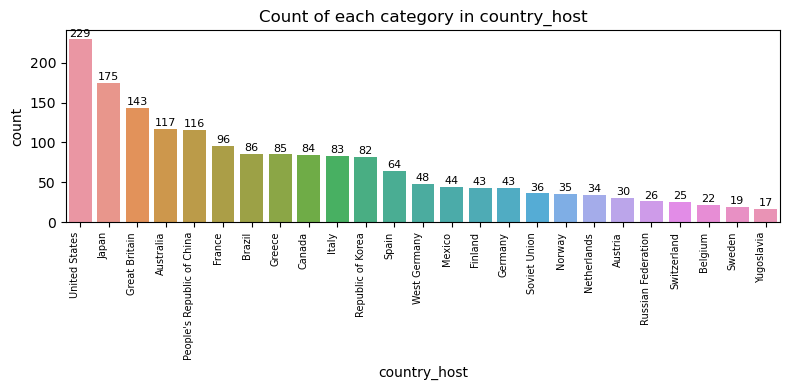

In [161]:
eda_visualization(df_games_medals)

In [162]:
#further analyze df_games_medals 
df_comparison = df_games_medals.groupby(['country_host', 'edition', 'year', 'country_performing'], as_index=False)[['total', 'gold', 'silver', 'bronze']].sum() \
    .groupby('edition', group_keys=False) \
    .apply(lambda x: x.nlargest(8,'total'))

In [163]:
df_comparison.head()

,country_host,edition,year,country_performing,total,gold,silver,bronze
670,Greece,1896 Summer Olympics,1896,Greece,47,10,18,19
674,Greece,1896 Summer Olympics,1896,United States,20,11,7,2
668,Greece,1896 Summer Olympics,1896,Germany,13,6,5,2
667,Greece,1896 Summer Olympics,1896,France,11,5,4,2
669,Greece,1896 Summer Olympics,1896,Great Britain,7,2,3,2


In [164]:
#add dummy variabe for season
df_comparison['season'] = [1 if 'Winter' in edition else 0 for edition in df_comparison['edition']]

In [165]:
#add another dummy variable for is_host

df_comparison['is_host'] = np.where(df_comparison['country_host'] == df_comparison['country_performing'], 1, 0)

In [166]:
df_summer = df_comparison[df_comparison['season'] == 0]
df_summer2 = df_summer.groupby(['year', 'is_host'])['total'].sum()
df_summer2 = pd.DataFrame(df_summer2)
df_summer2.reset_index(inplace=True)
df_summer2.head()

,year,is_host,total
0,1896,0,68
1,1896,1,47
2,1900,0,135
3,1900,1,111
4,1904,0,32


<strong><i>Does being a host country appear to furnish an advantage?</i></strong>
<br>
For most years, the host country wins medals. The number of medals won by the host country appears to be more sizable during the summer games than the winter ones. Though some countries are repeatedly hosting the games and could simply be strong contenders, it is likely still an influential factor. We will include is_host and season as two binary variables to capture this potential effect. 


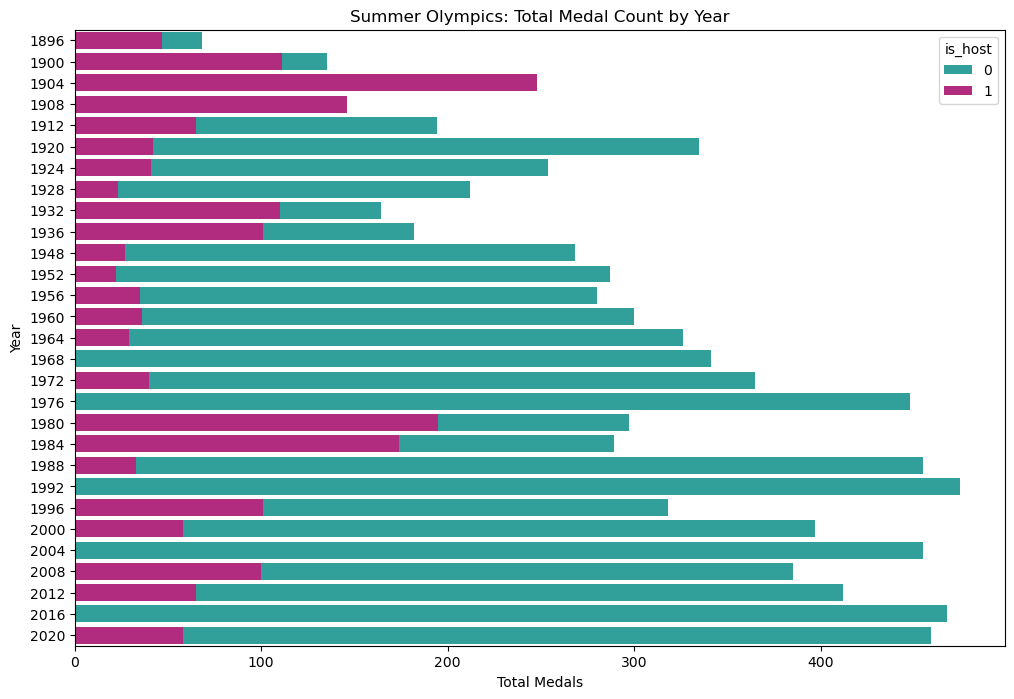

In [167]:
#plot summer games
plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_summer2, dodge=False, ci=None,palette={1: 'mediumvioletred', 0: 'lightseagreen'}, orient='h')
plt.title('Summer Olympics: Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

In [169]:
#plot winter games

df_winter = df_comparison[df_comparison['season'] == 1]
df_winter2 = df_winter.groupby(['year', 'is_host'])['total'].sum()
df_winter2 = pd.DataFrame(df_winter2)
df_winter2.reset_index(inplace=True)
df_winter2.head()

,year,is_host,total
0,1924,0,44
1,1924,1,3
2,1928,0,37
3,1932,0,28
4,1932,1,12


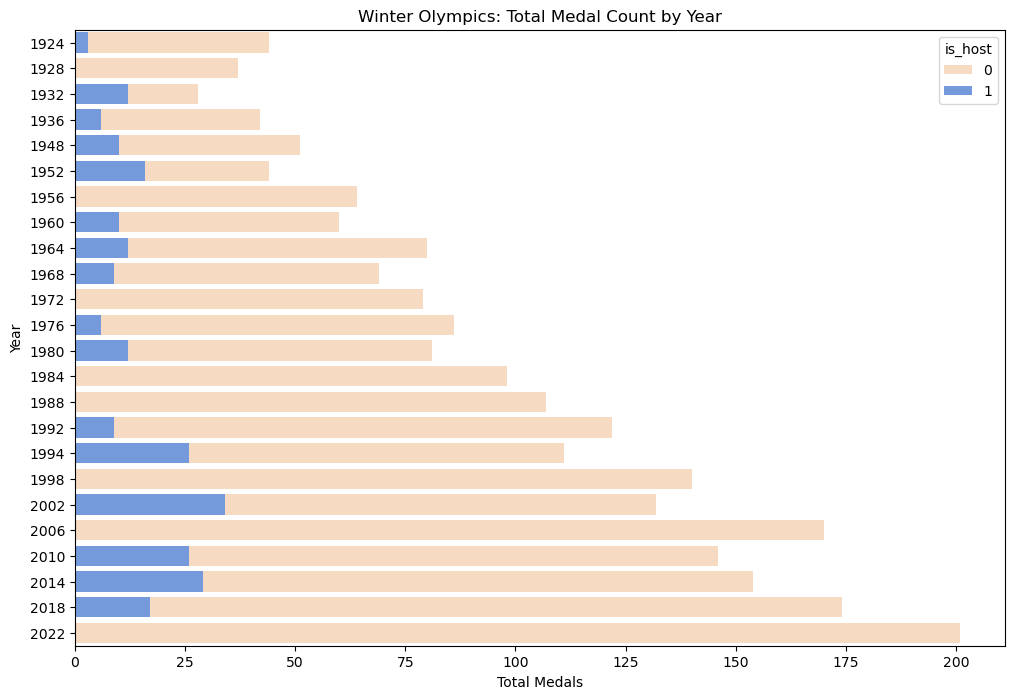

In [170]:

plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_winter2, dodge=False, ci=None,palette={1: 'cornflowerblue', 0: 'peachpuff'}, orient='h')
plt.title('Winter Olympics: Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

In [558]:
#lets explore the summer games by excluding usa 

df_summer_nousa = df_comparison[(df_comparison['season'] == 0) & (df_comparison['country_performing'] != 'United States')]
df_summer_nousa2 = df_summer_nousa.groupby(['year', 'is_host'])['total'].sum()
df_summer_nousa2= pd.DataFrame(df_summer_nousa2)
df_summer_nousa2.reset_index(inplace=True)
df_summer_nousa2.head()

,year,is_host,total
0,1896,0,48
1,1896,1,47
2,1900,0,87
3,1900,1,111
4,1904,0,32


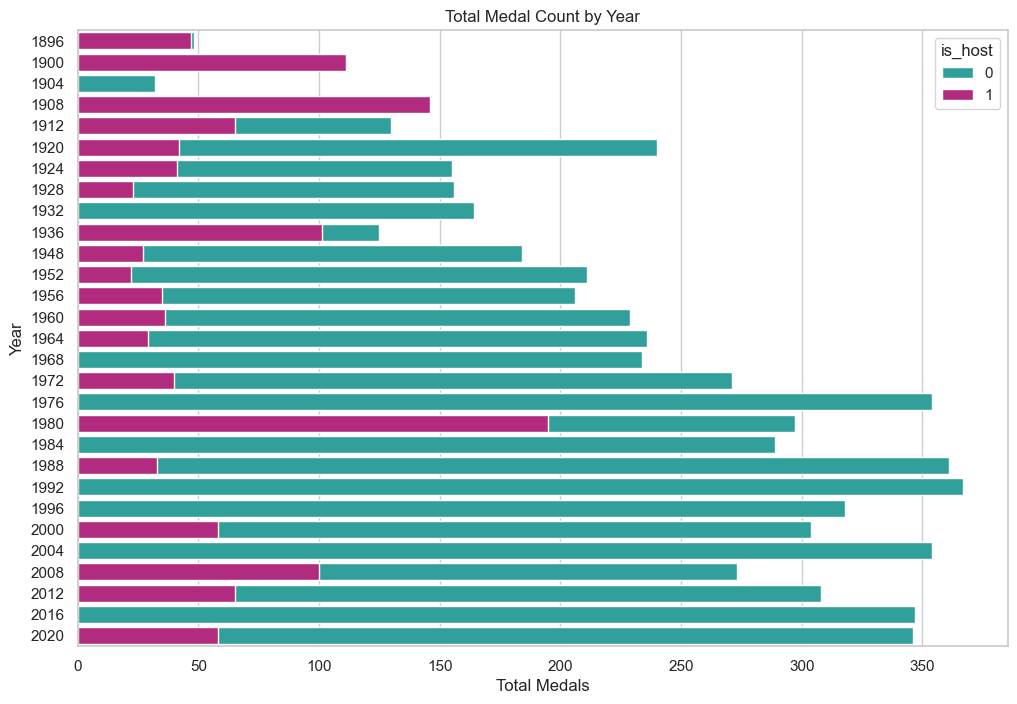

In [559]:
plt.figure(figsize=(12, 8))
sns.barplot(x='total', y='year', hue='is_host', data=df_summer_nousa2, dodge=False, ci=None,palette={1: 'mediumvioletred', 0: 'lightseagreen'}, orient='h')
plt.title('Total Medal Count by Year')
plt.xlabel('Total Medals')
plt.ylabel('Year')
plt.show()

<strong> Start building model:</strong>

In [560]:
def plot_residuals(actual_values, predicted_values, title='Residual Plot'):  
    sns.set_style('darkgrid')
    residuals = actual_values - predicted_values

    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=actual_values, y=residuals, color='lightblue')
    plt.axhline(y=0, color='red', linestyle='--')

    plt.title(f'{title}', fontsize=12)
    plt.xlabel('Actual Values', fontsize=10)
    plt.ylabel('Residuals', fontsize=10)
    plt.grid(True)
    plt.show()

In [561]:
results = []

In [562]:
def record_results(model):
    global results
    results.append({
        'model':f'{model}',
        'MSE train': f'{mse_train}',
        'MSE test': f'{mse_test}',
        'RMSE train': f'{np.sqrt(mse_train)}',
        'RMSE test': f'{np.sqrt(mse_test)}',
        'R2 train': f'{r2_score(y_train, base_train_predictions)}',
        'R2 test': f'{r2_score(y_test, base_predictions)}'
    })
    print('results recorded')

In [563]:
#Building a baseline model

#Model 1: Using data for the 2020 Olympics only

#start building df to predict medal count at the 2024 summer games

df_games_medals['is_host'] = np.where(df_games_medals['country_host'] == df_games_medals['country_performing'], 1, 0)

#add gdp and population-using already processed df saved in the data folder

df_gdp_pop = pd.merge(df_gdp_mean,df_pop_mean, on='country_noc', how='left')
df_gdp_pop.drop(['country_x', 'Country Code_x', 'country_y', 'Country Code_y'], axis=1, inplace=True)

In [564]:
#cols for model
df_cols = df_games_medals[['year','edition', 'country_noc_performing', 'gold', 'silver', 'bronze','total', 'is_host']]

In [565]:
df_cols.rename({'country_noc_performing':'country_noc'}, axis=1, inplace=True)
df_cols.head()

,year,edition,country_noc,gold,silver,bronze,total,is_host
0,1896,1896 Summer Olympics,USA,11,7,2,20,0
1,1896,1896 Summer Olympics,GRE,10,18,19,47,1
2,1896,1896 Summer Olympics,GER,6,5,2,13,0
3,1896,1896 Summer Olympics,FRA,5,4,2,11,0
4,1896,1896 Summer Olympics,GBR,2,3,2,7,0


In [566]:
#merge
df_model = pd.merge(df_cols, df_gdp_pop[['country_noc','mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm']], on='country_noc', how='left')


In [567]:
#add contingent size 
contingent_size = df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].nunique()

df_model2 = pd.merge(df_model, contingent_size[['edition','country_noc','athlete']], on=['edition','country_noc'], how='left')
df_model2.head()

,year,edition,country_noc,gold,silver,bronze,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,athlete
0,1896,1896 Summer Olympics,USA,11,7,2,20,0,20260.0,325.537793,22.0
1,1896,1896 Summer Olympics,GRE,10,18,19,47,1,210.3,10.756997,138.0
2,1896,1896 Summer Olympics,GER,6,5,2,13,0,3822.0,82.475589,20.0
3,1896,1896 Summer Olympics,FRA,5,4,2,11,0,2708.0,67.030750,18.0
4,1896,1896 Summer Olympics,GBR,2,3,2,7,0,2880.0,65.989286,15.0


In [568]:
df_model2.rename({'athlete':'contingent_size'}, axis=1,inplace=True)

In [569]:
#number of events they participate in

event_participation =  df_event_results.groupby(['edition', 'country_noc'], 
                                                                 as_index=False)['event'].nunique()

df_model3 = pd.merge(df_model2, event_participation[['edition','country_noc','event']], on=['edition','country_noc'], how='left')
df_model3.rename({'event':'event_count'}, axis=1, inplace=True)
df_model3.head()

,year,edition,country_noc,gold,silver,bronze,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count
0,1896,1896 Summer Olympics,USA,11,7,2,20,0,20260.0,325.537793,22.0,20.0
1,1896,1896 Summer Olympics,GRE,10,18,19,47,1,210.3,10.756997,138.0,40.0
2,1896,1896 Summer Olympics,GER,6,5,2,13,0,3822.0,82.475589,20.0,30.0
3,1896,1896 Summer Olympics,FRA,5,4,2,11,0,2708.0,67.030750,18.0,26.0
4,1896,1896 Summer Olympics,GBR,2,3,2,7,0,2880.0,65.989286,15.0,24.0


In [570]:
#has country won medals in the past

prior_medals = pd.DataFrame(df_medals.groupby('country_noc')['total'].sum())
prior_medals.reset_index(inplace=True)
prior_medals.head()

,country_noc,total
0,AFG,2
1,AHO,1
2,ALG,17
3,ANZ,12
4,ARG,77


In [571]:
#add dummy
prior_medals['prior_medals'] = (prior_medals['total'] > 0).astype(int)

In [572]:
prior_medals.head()

,country_noc,total,prior_medals
0,AFG,2,1
1,AHO,1,1
2,ALG,17,1
3,ANZ,12,1
4,ARG,77,1


In [573]:
#using 2020 data only
df_2020 = df_model3.loc[df_model3['year']==2020]

In [574]:
df_2020.drop(['year', 'edition', 'gold', 'silver', 'bronze'], axis=1, inplace=True)

In [575]:
#add medals in prior games 

df_medals_2016= df_medals.loc[df_medals['year']==2016]
df_medals_2016.rename({'total':'2016_medals'}, axis=1, inplace=True)

In [576]:
#merge
df_2020_base = pd.merge(df_2020, df_medals_2016[['country_noc', '2016_medals']], how ='left', on=['country_noc'])
df_2020_base.head()

,country_noc,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,2016_medals
0,USA,113,0,20260.0,325.537793,628.0,244.0,121.0
1,CHN,88,0,13337.0,1394.510500,415.0,199.0,70.0
2,JPN,58,1,4893.0,126.642158,609.0,222.0,41.0
3,GBR,64,0,2880.0,65.989286,390.0,188.0,67.0
4,ROC,71,0,NaN,NaN,336.0,199.0,NaN


In [577]:
df_2020_base['2016_medals'].fillna(0, inplace=True)

In [578]:
df_2020_base.dropna(inplace=True)

In [579]:
df_2020_base.rename({'total':'total_medals'}, axis=1, inplace=True)

In [580]:
df_2020_base = pd.merge(df_2020_base, prior_medals[['country_noc', 'prior_medals']], 
                        on='country_noc', how='left')

In [581]:
#run a basic linear reg model
X = df_2020_base[['is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', '2016_medals', 'prior_medals']]
y = df_2020_base['total_medals']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

In [582]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [583]:
mse_test = mean_squared_error(y_test, base_predictions)
print(mse_test)

42.5140090148492


In [584]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(mse_train)

44.59628342712415


In [585]:
#add predictions to df 
df_2020_base['predicted_total_medals'] = base_model.predict(X)
df_2020_base.head()

,country_noc,total_medals,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,2016_medals,prior_medals,predicted_total_medals
0,USA,113,0,20260.0,325.537793,628.0,244.0,121.0,1,111.765676
1,CHN,88,0,13337.0,1394.510500,415.0,199.0,70.0,1,69.380826
2,JPN,58,1,4893.0,126.642158,609.0,222.0,41.0,1,56.672647
3,GBR,64,0,2880.0,65.989286,390.0,188.0,67.0,1,45.326512
4,ROC,71,0,1489.0,144.100000,336.0,199.0,0.0,1,34.903452


In [586]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

print(coef_df)

                 Feature  Coefficient
0                is_host     0.000000
1  mean_gdp_last_10yr_bn     0.002933
2  mean_pop_last_10yr_mm    -0.006703
3        contingent_size     0.015718
4            event_count     0.145833
5            2016_medals     0.098139
6           prior_medals     0.000000


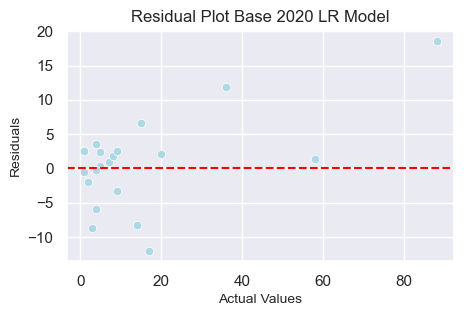

In [587]:
plot_residuals(y_test, base_predictions, title='Residual Plot Base 2020 LR Model')

In [588]:
record_results(model='Base 2020 LR')

results recorded


In [589]:
#Model 2- exlcuding USA, just testing if there is any improvement


df_2020_wo_usa = df_2020_base.loc[df_2020_base['country_noc']!= 'USA']

X = df_2020_wo_usa[['is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', '2016_medals', 'prior_medals']]
y = df_2020_wo_usa['total_medals']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

In [590]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [591]:
mse_test = mean_squared_error(y_test, base_predictions)
print(mse_test)

40.4681739261962


In [592]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(mse_train)

45.78064805217699


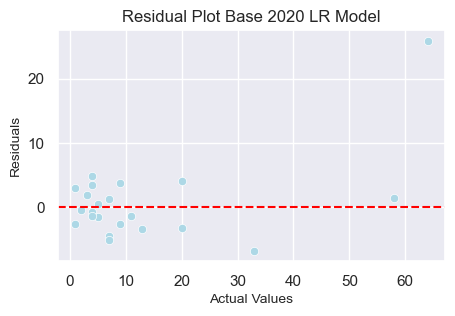

In [593]:
plot_residuals(y_test, base_predictions, title='Residual Plot Base 2020 LR Model')

In [594]:
record_results(model='Base 2020 LR no USA')

results recorded


In [595]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

print(coef_df)

                 Feature  Coefficient
0                is_host     0.000000
1  mean_gdp_last_10yr_bn     0.005369
2  mean_pop_last_10yr_mm    -0.009098
3        contingent_size    -0.000467
4            event_count     0.171965
5            2016_medals    -0.098480
6           prior_medals     0.000000


In [596]:
# Model 3: Trying with all the years instead of just 2020

In [597]:
# adding the season dummy 
df_model3['winter'] = [1 if 'Winter' in edition else 0 for edition in df_model3['edition']]

In [598]:
# merging 
df_model3 = df_model3.merge(prior_medals[['country_noc', 'prior_medals']], on='country_noc')

In [599]:
previous_year_df = df_model3.groupby(['country_noc', 'year', 'winter'], as_index=False)['total'].sum()

In [600]:
# we need this dataframe to add the previous year's(event's) medal total to the current year's
previous_year_df['year'] = previous_year_df['year']+4

In [601]:
previous_year_df.rename(columns={'total':'previous_year_medals'}, inplace=True)

In [602]:
df_model3 = df_model3.merge(previous_year_df, on=['country_noc', 'year', 'winter'], how='left')

In [603]:
df_model3['previous_year_medals'].fillna(0, inplace=True)

In [604]:
df_model3.drop(['edition', 'gold', 'silver', 'bronze'], axis=1, inplace=True)

In [605]:
# we will switch to a data source that has these missing values in the future and deletion wont be needed
df_model3.dropna(inplace=True)

In [606]:
df_model3.head()

,year,country_noc,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,winter,prior_medals,previous_year_medals
0,1896,USA,20,0,20260.0,325.537793,22.0,20.0,0,1,0.0
1,1900,USA,48,0,20260.0,325.537793,93.0,63.0,0,1,20.0
2,1904,USA,248,1,20260.0,325.537793,1239.0,164.0,0,1,48.0
3,1908,USA,47,0,20260.0,325.537793,152.0,54.0,0,1,248.0
4,1912,USA,64,0,20260.0,325.537793,221.0,69.0,0,1,47.0


In [607]:
X = df_model3[['year','is_host', 'mean_gdp_last_10yr_bn', 'mean_pop_last_10yr_mm', 'contingent_size',
            'event_count', 'previous_year_medals', 'prior_medals',
              'winter']]

y = df_model3['total']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101, stratify=df_model3['year']) 

In [608]:
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

In [609]:
mse_test = mean_squared_error(y_test, base_predictions)
print(np.sqrt(mse_test), mse_test) 

8.707084841045 75.81332642915564


In [610]:
base_train_predictions = base_model.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions)
print(np.sqrt(mse_train), mse_train) 

8.207986529789922 67.37104287321282


In [611]:
coefficients = base_model.coef_

# coefficients with their corresponding feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

coef_df

,Feature,Coefficient
0,year,-0.001369
1,is_host,1.501355
2,mean_gdp_last_10yr_bn,0.000996
3,mean_pop_last_10yr_mm,-0.002680
4,contingent_size,0.135862
5,event_count,-0.115744
6,previous_year_medals,0.237384
7,prior_medals,0.000000
8,winter,-1.102269


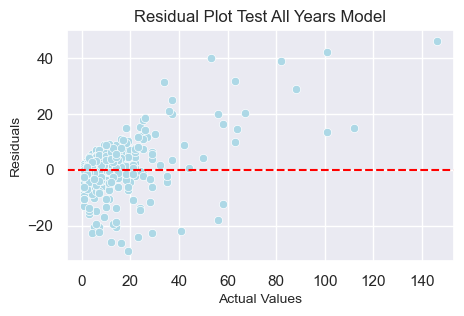

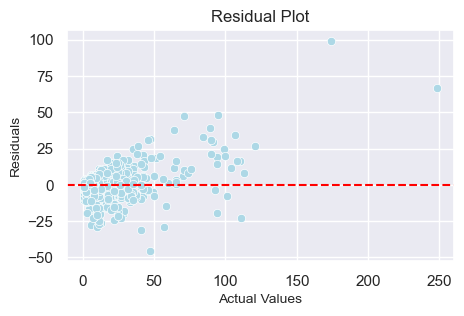

In [612]:
plot_residuals(y_test, base_predictions, title='Residual Plot Test All Years Model')
plot_residuals(y_train, base_train_predictions)

In [613]:
record_results(model='Base all years LR')

results recorded


In [614]:
pd.DataFrame(results).T

,0,1,2
model,Base 2020 LR,Base 2020 LR no USA,Base all years LR
MSE train,44.59628342712415,45.78064805217699,67.37104287321282
MSE test,42.5140090148492,40.4681739261962,75.81332642915564
RMSE train,6.678044880586245,6.7661398191418565,8.207986529789922
RMSE test,6.520276759068529,6.361460046734256,8.707084841045
R2 train,0.876409568829278,0.8203674369340623,0.7999841586834336
R2 test,0.9005919023194648,0.8570457096751479,0.7264690169854559


<strong> Evaluation </strong>

The base LR model using 2020 data performs best in terms of MSE, especially when dropping the US as a country. The magnitude of the errors is lower, and the number of medals predicted go from being off by 6.5 to 6.3 (decimals are a result of using a linear regression model on count data). However, the difference between the train and test MSEs in the second fitting that drops the USA is larger. Since such a significant outlier was removed, the model is perhaps overfitting on noise that it can now better perceive. Some collinearity between variables like contingent size and event count, prior medals and previous year medals, etc. could also contribute. The R2 for the fitting without the USA is lower than that of the first, possibly because removing a row of data in a small dataset can cause information loss that affects the overall goodness of fit. Meanwhile, the base model applied to all years performs the worst, with a larger difference in train-test scores and generally worse metrics. 

Considering that the assumptions of linear regression are violated (e.g. heteroscedasticity, independence of observations, possible collinearity, etc.), this base model performs well. Going forward, it will be important to address the time component of the data (whether it means focusing on a smaller dataset or using all years) and the treatment of outliers like the USA (e.g., taking the log may improve the model). Moreover, since the model performs well initially, the possibilty of information leakage exists; the model may be capable of inferring a certain year's medal count based on the medal counts available for that year in the training data. 

Data size is another aspect: if only one year is used, the data shrinks to around 80 rows, which is not a robust number. We may need to explore data generation/oversampling techniques, or find a time-series appropriate solution that allows the use of more years. In terms of modelling, we look forward to exploring methods for count data, such as random forest, gradient boosting, poisson regression, etc. 

This base model furnishes a first glimpse of the feature importances. Being a host increases the medal tally by 1.5, all things equal, while winter seems to decrease it by 1.1. Previous year medals and contingent size also have a somewhat smaller, positive contribution. Applied to 2020 data, the important features become the number of events partaken in. Interestingly, the sign switches for 2016_medals after removing the USA; they are decreasing the the medals won by a country in 2020. We are currently working on adding more variables, for example related to climate, pollution, distance to the host country, etc. These are country inherent characteristics that are likely to impact the performance of athletes and in turn, the total medals. 

<strong>Ongoing Work:</strong>

In [615]:
# add pollution variable (greenhouse gas emissions) 
ghg_df = pd.read_excel('data/raw/GHG.xlsx', sheet_name='GHG_per_capita_by_country')

In [616]:
#ghg_df.isna().sum() 
ghg_df.head()

,EDGAR Country Code,Country,country_noc,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,ABW,Aruba,ARU,0.764874,0.842243,1.017002,1.093028,1.075665,1.304510,1.290385,1.472615,1.559235,1.628306,1.691492,1.732087,1.702076,1.720133,1.936028,2.020452,2.187511,2.455545,2.716328,3.621398,3.449435,3.742765,3.909436,3.729530,3.879263,4.073369,2.713474,4.134453,4.146225,3.958565,3.695699,3.704442,3.823711,4.249212,4.356899,4.625041,4.567732,4.948591,4.864886,5.193761,4.991757,3.303429,3.996863,4.495219,4.577104,4.566385,4.713839,4.438256,4.751366,5.429571,4.648065,4.478428,4.641895
1,AFG,Afghanistan,AFG,1.558155,1.514547,1.308854,1.327430,1.402300,1.428421,1.400988,1.389203,1.337125,1.314733,1.322558,1.349348,1.377107,1.411930,1.364306,1.389247,1.262597,1.237538,1.247701,1.160737,1.124622,1.066259,0.922929,0.865919,0.817958,0.796788,0.839897,0.873737,0.896454,0.924537,0.798526,0.686233,0.775468,0.768801,0.737570,0.725598,0.712960,0.737037,0.845966,0.939622,1.048180,1.160279,1.057582,0.973788,0.952880,0.925066,0.882018,0.894256,0.864369,0.814933,0.739738,0.744043,0.731973
2,AGO,Angola,ANG,2.971847,2.889799,3.202473,3.349278,3.355909,3.109663,2.526316,3.028038,3.193999,3.164644,3.119263,2.856599,2.785448,2.877701,2.874100,2.951811,3.013942,3.126238,3.269973,3.218030,2.872064,2.774224,2.617820,2.818344,3.534781,3.948525,4.588396,4.653318,4.867774,4.780026,4.346559,4.080620,3.872635,3.752265,3.945102,3.760844,3.284934,3.129757,3.218966,3.156319,3.343341,3.166645,3.124498,3.191958,3.164378,3.234489,3.022751,2.749379,2.541601,2.436028,2.183618,2.053871,1.900082
3,AIA,Anguilla,NaN,0.664745,0.659985,0.670368,0.640851,0.674738,0.707861,0.679611,0.692013,0.744485,0.789514,0.974433,1.327599,1.409396,1.272228,1.224293,0.874800,0.782080,1.185736,1.097302,1.101894,1.061477,1.207306,1.213080,1.412188,1.725195,2.035552,1.974572,1.670396,1.529383,1.437092,1.751396,1.755301,1.269643,1.519973,1.436375,1.425603,1.335258,1.277653,1.517357,1.840025,2.105050,2.228272,2.205060,2.319825,2.294322,2.280345,2.284678,2.313661,2.235358,2.174801,1.839092,1.817830,1.873253
4,ALB,Albania,ALB,3.841370,3.726499,4.055711,3.744120,3.776578,3.779692,3.951595,4.088050,4.398859,4.750278,4.728916,4.279079,4.428535,4.643154,4.656857,4.407872,4.374518,4.354657,4.222022,4.115201,3.525317,2.773477,1.911686,1.953619,2.205151,2.113809,2.039308,1.797647,1.877935,2.259746,2.322697,2.384598,2.588361,2.656858,2.736368,2.620855,2.657027,2.669268,2.625801,2.643967,2.768820,2.919185,2.826554,2.917092,3.083604,3.025938,2.891528,3.167459,3.145276,2.975907,2.672676,2.682786,2.708985


In [617]:
ghg_df.drop(columns=['EDGAR Country Code','Country'], inplace=True)

In [618]:
ghg_df = ghg_df[ghg_df['country_noc'].notna()]

In [619]:
ghg_df = pd.melt(ghg_df, id_vars=['country_noc'], var_name='year', value_name='ghg_per_capita')

In [620]:
ghg_df['year'] = ghg_df['year'].astype(int)
ghg_df.head()

,country_noc,year,ghg_per_capita
0,ARU,1970,0.764874
1,AFG,1970,1.558155
2,ANG,1970,2.971847
3,ALB,1970,3.841370
4,UAE,1970,124.734663


In [621]:
# country_code_mappings = {'GRC':'GRE',
#  'DEU':'GER',
#  'DNK':'DEN',
#  'CHE':'SUI',
#  'NLD':'NED',
# #  'ZAF':'RSA',
#  'URY':'URU',
#  'PRT':'POR',
#  'CHL':'CHI',
#  'PHL':'PHI',
#  'LVA':'LAT',
#  'LKA':'SRI',
#  'IRN':'IRI',
#  'PRI':'PUR',
#  'BGR':'BUL',
#  'NGA':'NGR',
#  'MNG':'MGL',
#  'NER':'NIG',
#  'BMU':'BER',
#  'ZWE':'ZIM',
#  'DZA':'ALG',
#  'ZMB':'ZAM',
#  'CRI':'CRC',
#  'IDN':'INA',
#  'HRV':'CRO',
#  'SVN':'SLO',
#  'MYS':'MAS',
#  'TON':'TGA',
#  'SAU':'KSA',
#  'VNM':'VIE',
#  'BRB':'BAR',
#  'KWT':'KUW',
#  'ARE':'UAE',
#  'PRY':'PAR',
#  'SCG':'SRB',
#  'WSM':'SAM',
#  'SDN':'SUD',
#  'MUS':'MRI',
#  'TGO':'TOG',
#  'GRD':'GRN',
#  'BWA':'BOT',
#  'GTM':'GUA',
#  'SCG':'MNE',
#  'FJI':'FIJ',
#  'ITA':'SMR',
#  'BFA':'BUR'}

In [622]:
# ghg_df.replace(country_code_mappings, inplace=True)

In [623]:
# just using this to get the country_noc > country map to compare with the one in the greenhouse gas data ones
# df_model3.merge(df_country, on='country_noc', how='left').groupby(['country_noc', 'country'], as_index=False).count()

In [624]:
# getting unmatched country ids even though theyre in both datasets ahh
# df_model3 = df_model3.merge(ghg_df, how='left', left_on=['country_noc', 'year'], right_on=['EDGAR Country Code', 'year'])

In [625]:
# df_model3[(df_model3['year']>1970)&df_model3.isna().any(axis=1)]['country_noc'].unique()

In [626]:
# ghg_df['EDGAR Country Code'].unique()

In [627]:
#bring in temperature data
temp_df = pd.read_csv('data/raw/temperature.csv')
temp_df.head()

,place,pop2023,growthRate,area,country,country_noc,cca3,cca2,ccn3,region,subregion,unMember,officialName,landAreaKm,density,densityMi,Rank,hottestCountriesInTheWorld_averageTemperature,avg_temp
0,356,1428627663,0.00808,3287590.0,India,IND,IND,IN,356,Asia,"Southern Asia, South Central Asia",True,Republic of India,2973190.0,480.5033,1244.5036,1,23.65,74.57
1,156,1425671352,-0.00015,9706961.0,China,CHN,CHN,CN,156,Asia,Eastern Asia,True,People's Republic of China,9424702.9,151.2696,391.7884,2,6.95,44.51
2,840,339996563,0.00505,9372610.0,United States,USA,USA,US,840,North America,Northern America,True,United States of America,9147420.0,37.1686,96.2666,3,8.55,47.39
3,360,277534122,0.00738,1904569.0,Indonesia,INA,IDN,ID,360,Asia,South-Eastern Asia,True,Republic of Indonesia,1877519.0,147.8196,382.8528,4,25.85,78.53
4,586,240485658,0.01976,881912.0,Pakistan,PAK,PAK,PK,586,Asia,"Southern Asia, South Central Asia",True,Islamic Republic of Pakistan,770880.0,311.9625,807.9829,5,20.20,68.36


In [628]:
#bring in olympic incentives
incentives_df = pd.read_csv('data/raw/medal_incentives.csv')
incentives_df.rename({'Gold': 'incentive_gold'}, axis=1, inplace=True)
incentives_df.head()

,Countries,country_noc,offers_incentive,incentive_gold,Silver,Bronze
0,Australia,AUS,Yes,15000,11000,7000
1,Azerbaijan,AZE,Yes,235000,117500,58750
2,Brazil,BRA,Yes,49000,29000,20000
3,Bulgaria,BUL,Yes,91008,72806,54605
4,Canada,CAN,Yes,16000,12000,8000


In [629]:
#melting gdp 

df_country3 = df_country2.drop(['country', 'Country Name', 'Country Code', 'mean_gdp_last_10yr_bn'], axis=1)
df_country3 = pd.melt(df_country3, id_vars=['country_noc'], var_name='year', value_name='gdp')
df_country3.head()

,country_noc,year,gdp
0,AFG,1960,0.537778
1,ALB,1960,NaN
2,ALG,1960,2.723615
3,ASA,1960,NaN
4,AND,1960,NaN


In [630]:
df_country3.year = df_country3.year.astype(int)

In [631]:
df_pop2.head()

,country_noc,country,Country_Updated,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_pop_last_10yr_mm
0,AFG,Afghanistan,Afghanistan,AFG,8.622466,8.790140,8.969047,9.157465,9.355514,9.565147,9.783147,10.010030,10.247780,10.494489,10.752971,11.015857,11.286753,11.575305,11.869879,12.157386,12.425267,12.687301,12.938862,12.986369,12.486631,11.155195,10.088289,9.951449,10.243686,10.512221,10.448442,10.322758,10.383460,10.673168,10.694796,10.745167,12.057433,14.003760,15.455555,16.418912,17.106595,17.788819,18.493132,19.262847,19.542982,19.688632,21.000256,22.645130,23.553551,24.411191,25.442944,25.903301,26.427199,27.385307,28.189672,29.249157,30.466479,31.541209,32.716210,33.753499,34.636207,35.643418,36.686784,37.769499,38.972230,40.099462,41.128771,36.294729
1,ALB,Albania,Albania,ALB,1.608800,1.659800,1.711319,1.762621,1.814135,1.864791,1.914573,1.965598,2.022272,2.081695,2.135479,2.187853,2.243126,2.296752,2.350124,2.404831,2.458526,2.513546,2.566266,2.617832,2.671997,2.726056,2.784278,2.843960,2.904429,2.964762,3.022635,3.083605,3.142336,3.227943,3.286542,3.266790,3.247039,3.227287,3.207536,3.187784,3.168033,3.148281,3.128530,3.108778,3.089027,3.060173,3.051010,3.039616,3.026939,3.011487,2.992547,2.970017,2.947314,2.927519,2.913021,2.905195,2.900401,2.895092,2.889104,2.880703,2.876101,2.873457,2.866376,2.854191,2.837849,2.811666,2.775634,2.856017
2,ALG,Algeria,Algeria,DZA,11.394307,11.598608,11.778260,11.969451,12.179099,12.381256,12.613389,12.897115,13.190975,13.491016,13.795915,14.110271,14.439748,14.786469,15.153602,15.724692,16.500516,17.134192,17.632645,18.166981,18.739378,19.351357,20.000096,20.682111,21.393530,22.132905,22.882553,23.586101,24.243018,24.889507,25.518074,26.133905,26.748303,27.354327,27.937006,28.478022,28.984634,29.476031,29.924668,30.346083,30.774621,31.200985,31.624696,32.055883,32.510186,32.956690,33.435080,33.983827,34.569592,35.196037,35.856344,36.543541,37.260563,38.000626,38.760168,39.543154,40.339329,41.136546,41.927007,42.705368,43.451666,44.177969,44.903225,41.494506
3,ASA,American Samoa,American Samoa,ASM,0.020085,0.020626,0.021272,0.021949,0.022656,0.023391,0.024122,0.024848,0.025608,0.026396,0.027075,0.027593,0.028063,0.028529,0.029012,0.029573,0.030198,0.030816,0.031428,0.032045,0.032886,0.034059,0.035367,0.036735,0.038168,0.039663,0.041221,0.042842,0.044532,0.046288,0.047818,0.048992,0.050078,0.051174,0.052288,0.053401,0.054500,0.055578,0.056603,0.057594,0.058230,0.058324,0.058177,0.057941,0.057626,0.057254,0.056837,0.056383,0.055891,0.055366,0.054849,0.054310,0.053691,0.052995,0.052217,0.051368,0.050448,0.049463,0.048424,0.047321,0.046189,0.045035,0.044273,0.048773
4,AND,Andorra,Andorra,AND,0.009443,0.010216,0.011014,0.011839,0.012690,0.013563,0.014546,0.015745,0.017079,0.018449,0.019860,0.021322,0.022832,0.024393,0.026003,0.027640,0.029294,0.030949,0.032574,0.034142,0.035611,0.036987,0.038598,0.040432,0.042181,0.043809,0.045605,0.047635,0.049654,0.051639,0.053569,0.055434,0.057283,0.059156,0.061037,0.062928,0.064147,0.064682,0.065186,0.065655,0.066097,0.067820,0.070849,0.073907,0.076933,0.079826,0.080221,0.078168,0.076055,0.073852,0.071519,0.070567,0.071013,0.071367,0.071621,0.071746,0.072540,0.073837,0.075013,0.076343,0.077700,0.079034,0.079824,0.074902


In [632]:
#melt population

df_pop3 = df_pop2.drop(['country', 'Country_Updated', 'Country Code', 'mean_pop_last_10yr_mm'], axis=1)
df_pop3 = pd.melt(df_pop3, id_vars=['country_noc'], var_name='year', value_name='population')
df_pop3.head()

,country_noc,year,population
0,AFG,1960,8.622466
1,ALB,1960,1.608800
2,ALG,1960,11.394307
3,ASA,1960,0.020085
4,AND,1960,0.009443


In [633]:
df_pop3.year = df_pop3.year.astype(int)

In [634]:
## merge with df_model3

df_model4 = pd.merge(df_model3, incentives_df[['country_noc', 'offers_incentive', 'incentive_gold']], 
                          on='country_noc', how='left')

df_model4.offers_incentive = df_model4.offers_incentive.fillna(0)
df_model4.incentive_gold = df_model4.incentive_gold.fillna(0)

In [635]:
df_model4.head()

,year,country_noc,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,winter,prior_medals,previous_year_medals,offers_incentive,incentive_gold
0,1896,USA,20,0,20260.0,325.537793,22.0,20.0,0,1,0.0,Yes,37500.0
1,1900,USA,48,0,20260.0,325.537793,93.0,63.0,0,1,20.0,Yes,37500.0
2,1904,USA,248,1,20260.0,325.537793,1239.0,164.0,0,1,48.0,Yes,37500.0
3,1908,USA,47,0,20260.0,325.537793,152.0,54.0,0,1,248.0,Yes,37500.0
4,1912,USA,64,0,20260.0,325.537793,221.0,69.0,0,1,47.0,Yes,37500.0


In [636]:
df_model4.offers_incentive = df_model4.offers_incentive.map({'Yes': 1, 'No': 0})
df_model4.offers_incentive = df_model4.offers_incentive.fillna(0)

In [637]:
#now merge temp

df_model4 = pd.merge(df_model4, temp_df[['country_noc','avg_temp']], on='country_noc', how='left')

In [638]:
df_model4.avg_temp = df_model4.avg_temp.fillna(0)

In [639]:
#impute mean for missing temp values 
mean_temp = df_model4['avg_temp'].mean()
df_model4['avg_temp'].fillna(mean_temp, inplace=True)

In [640]:
df_model4.head()

,year,country_noc,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,winter,prior_medals,previous_year_medals,offers_incentive,incentive_gold,avg_temp
0,1896,USA,20,0,20260.0,325.537793,22.0,20.0,0,1,0.0,1.0,37500.0,47.39
1,1900,USA,48,0,20260.0,325.537793,93.0,63.0,0,1,20.0,1.0,37500.0,47.39
2,1904,USA,248,1,20260.0,325.537793,1239.0,164.0,0,1,48.0,1.0,37500.0,47.39
3,1908,USA,47,0,20260.0,325.537793,152.0,54.0,0,1,248.0,1.0,37500.0,47.39
4,1912,USA,64,0,20260.0,325.537793,221.0,69.0,0,1,47.0,1.0,37500.0,47.39


In [641]:
#merge with emissions

df_model4 = pd.merge(df_model4, ghg_df[['country_noc', 'year', 'ghg_per_capita'
                                     ]], on=['country_noc', 'year'], how='left')

In [642]:
df_model4.dropna(subset=['ghg_per_capita', 'mean_pop_last_10yr_mm','mean_gdp_last_10yr_bn'], inplace=True)


In [643]:
df_model4.head()

,year,country_noc,total,is_host,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,contingent_size,event_count,winter,prior_medals,previous_year_medals,offers_incentive,incentive_gold,avg_temp,ghg_per_capita
16,1972,USA,94,0,20260.0,325.537793,410.0,180.0,0,1,107.0,1.0,37500.0,47.39,27.627188
17,1976,USA,94,0,20260.0,325.537793,399.0,177.0,0,1,94.0,1.0,37500.0,47.39,27.185793
18,1984,USA,174,1,20260.0,325.537793,577.0,210.0,0,1,0.0,1.0,37500.0,47.39,24.502443
19,1988,USA,94,0,20260.0,325.537793,583.0,227.0,0,1,174.0,1.0,37500.0,47.39,25.042937
20,1992,USA,108,0,20260.0,325.537793,570.0,233.0,0,1,94.0,1.0,37500.0,47.39,24.140314


In [644]:
#drop mean gdp and pop
df_model4.drop(['mean_pop_last_10yr_mm', 'mean_gdp_last_10yr_bn'], axis=1, inplace=True)

In [645]:
#merge with gdp data
 
df_model4 = pd.merge(df_model4, df_country3[['country_noc', 'year', 'gdp']], on=['country_noc', 'year'], 
                     how='left')
df_model4.head()

,year,country_noc,total,is_host,contingent_size,event_count,winter,prior_medals,previous_year_medals,offers_incentive,incentive_gold,avg_temp,ghg_per_capita,gdp
0,1972,USA,94,0,410.0,180.0,0,1,107.0,1.0,37500.0,47.39,27.627188,1280.0
1,1976,USA,94,0,399.0,177.0,0,1,94.0,1.0,37500.0,47.39,27.185793,1870.0
2,1984,USA,174,1,577.0,210.0,0,1,0.0,1.0,37500.0,47.39,24.502443,4040.0
3,1988,USA,94,0,583.0,227.0,0,1,174.0,1.0,37500.0,47.39,25.042937,5240.0
4,1992,USA,108,0,570.0,233.0,0,1,94.0,1.0,37500.0,47.39,24.140314,6520.0


In [646]:
df_model4 = pd.merge(df_model4, df_pop3[['country_noc', 'year', 'population']], on=['country_noc', 'year'], 
                     how='left')
df_model4.head()

,year,country_noc,total,is_host,contingent_size,event_count,winter,prior_medals,previous_year_medals,offers_incentive,incentive_gold,avg_temp,ghg_per_capita,gdp,population
0,1972,USA,94,0,410.0,180.0,0,1,107.0,1.0,37500.0,47.39,27.627188,1280.0,209.896
1,1976,USA,94,0,399.0,177.0,0,1,94.0,1.0,37500.0,47.39,27.185793,1870.0,218.035
2,1984,USA,174,1,577.0,210.0,0,1,0.0,1.0,37500.0,47.39,24.502443,4040.0,235.825
3,1988,USA,94,0,583.0,227.0,0,1,174.0,1.0,37500.0,47.39,25.042937,5240.0,244.499
4,1992,USA,108,0,570.0,233.0,0,1,94.0,1.0,37500.0,47.39,24.140314,6520.0,256.514


In [647]:
df_model4.dropna(inplace=True)

In [648]:
df_model4.drop(['prior_medals'], axis=1, inplace=True)

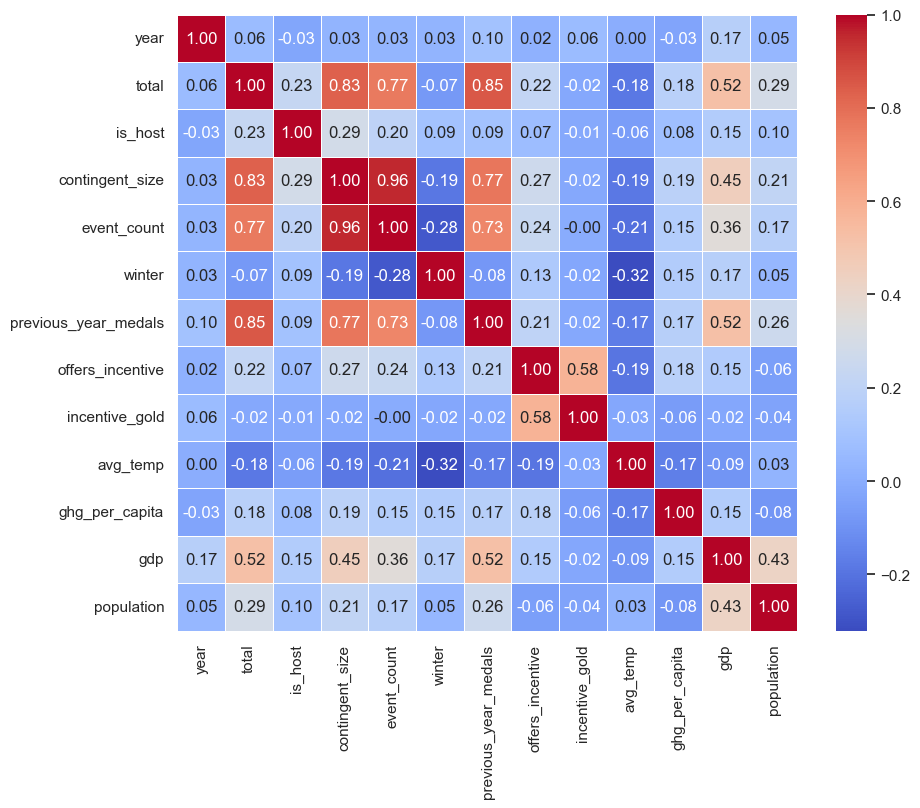

In [649]:
df_model4_corr = df_model4.drop(columns=['country_noc'])
correlation_matrix = df_model4_corr.corr()

#plot
plt.figure(figsize=(10, 8))
sns.set(style="white")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.show()

In [650]:
#df_model4.to_clipboard()

In [651]:
features= ['year','is_host', 'gdp', 'population', 'contingent_size',
            'event_count', 'previous_year_medals','offers_incentive', 'incentive_gold', 'avg_temp',
               'ghg_per_capita',
              'winter']

X = df_model4[features]

y = df_model4['total']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

In [652]:
base_model4 = LinearRegression()
base_model4.fit(X_train, y_train)
base_predictions4 = base_model4.predict(X_test)

In [653]:
mse_test = mean_squared_error(y_test, base_predictions4)
print(mse_test)

32.5397425741492


In [654]:
base_train_predictions4 = base_model4.predict(X_train)
mse_train = mean_squared_error(y_train, base_train_predictions4)
print(mse_train)

60.65616468731421


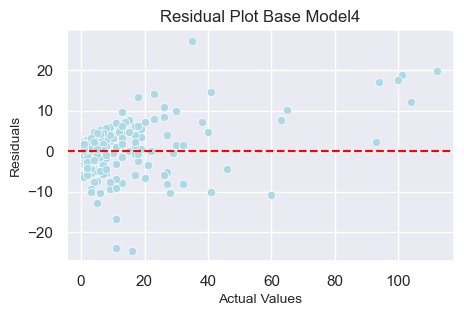

In [655]:
plot_residuals(y_test, base_predictions4, title='Residual Plot Base Model4')

In [656]:
#lets try a linear fixed effect model

#check for multicollinearity

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,year,28.561031
1,is_host,1.299881
2,gdp,1.990853
3,population,1.453235
4,contingent_size,38.855220
5,event_count,41.379147
6,previous_year_medals,3.945487
7,offers_incentive,3.047644
8,incentive_gold,2.018103
9,avg_temp,15.381225


In [657]:
#let us exclude event_count and try again
features= ['year','is_host', 'gdp', 'population', 'contingent_size',
            'previous_year_medals', 'incentive_gold', 
               'ghg_per_capita',
              'winter']


X = df_model4[features]

y = df_model4['total']

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.25, random_state=101) 

# Add constant for intercept
X_train = sm.add_constant(X_train)

# Fit fixed effects model
model = sm.OLS(y_train, X_train).fit()

# View model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     299.6
Date:                Sat, 09 Dec 2023   Prob (F-statistic):          1.31e-242
Time:                        16:41:49   Log-Likelihood:                -2669.8
No. Observations:                 767   AIC:                             5360.
Df Residuals:                     757   BIC:                             5406.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   23.6589 

In [658]:
#chcking vif again
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data


#the r-sq is good but something is still wrong with this model

,Variable,VIF
0,year,4.330807
1,is_host,1.213884
2,gdp,1.931005
3,population,1.426851
4,contingent_size,6.105474
5,previous_year_medals,3.922337
6,incentive_gold,1.201426
7,ghg_per_capita,2.834048
8,winter,1.649355


<strong>Athlete data analysis<strong>

In [6]:
df_athletes.head()

,athlete_id,name,sex,born,height,weight,country,country_noc,description,special_notes
0,16809,Károly Teppert,Male,1891-07-20,na,na,Hungary,HUN,Károly Teppert started competing in cycling in...,na
1,43737,Andrzej Socharski,Male,1947-08-31,173.0,72,Poland,POL,na,Listed in Olympians Who Won a Medal at the Wor...
2,50147,Nathalie Wunderlich,Female,1971-06-03,170.0,50,Switzerland,SUI,na,na
3,5085,Miha Lokar,Male,1935-09-10,182.0,76,Yugoslavia,YUG,na,Listed in Olympians Who Won a Medal at the Eur...
4,136329,Austin Hack,Male,1992-05-17,203.0,100,United States,USA,na,na


In [177]:
df_event_results.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport
0,1908 Summer Olympics,5,ANZ,Athletics,"100 metres, Men",56265,Ernest Hutcheon,64710,DNS,na,False
1,1908 Summer Olympics,5,ANZ,Athletics,"400 metres, Men",56313,Henry Murray,64756,DNS,na,False
2,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",56338,Harvey Sutton,64808,3 h8 r1/2,na,False
3,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",56338,Guy Haskins,922519,DNS,na,False
4,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",56338,Joseph Lynch,64735,DNS,na,False


In [184]:
#merge athlete with event results
df_athletes_events = pd.merge(df_athletes[['name', 'sex', 'born', 'height', 'weight', 'country_noc']],
                              df_event_results[['athlete','edition', 'sport', 'event', 'medal', 'isTeamSport']],
                              left_on='name', right_on='athlete', how='inner')
df_athletes_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325309 entries, 0 to 325308
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   name         325309 non-null  object
 1   sex          325309 non-null  object
 2   born         325309 non-null  object
 3   height       325309 non-null  object
 4   weight       325309 non-null  object
 5   country_noc  325309 non-null  object
 6   athlete      325309 non-null  object
 7   edition      325309 non-null  object
 8   sport        325309 non-null  object
 9   event        325309 non-null  object
 10  medal        325309 non-null  object
 11  isTeamSport  325309 non-null  bool  
dtypes: bool(1), object(11)
memory usage: 27.6+ MB


In [185]:
df_athletes_events.head()

,name,sex,born,height,weight,country_noc,athlete,edition,sport,event,medal,isTeamSport
0,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Individual, Men",na,False
1,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Team, Men",na,True
2,Andrzej Socharski,Male,1947-08-31,173.0,72,POL,Andrzej Socharski,1976 Summer Olympics,Shooting,"Skeet, Open",na,False
3,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"100 metres Backstroke, Women",na,False
4,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"200 metres Backstroke, Women",na,False


In [188]:
#merge with games

df_athletes_events2 = pd.merge(df_athletes_events, df_games[['edition', 'year', 'country_noc']],on='edition', how='left')

df_athletes_events2.head()

,name,sex,born,height,weight,country_noc_x,athlete,edition,sport,event,medal,isTeamSport,year,country_noc_y
0,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Individual, Men",na,False,1912.0,SWE
1,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Team, Men",na,True,1912.0,SWE
2,Andrzej Socharski,Male,1947-08-31,173.0,72,POL,Andrzej Socharski,1976 Summer Olympics,Shooting,"Skeet, Open",na,False,1976.0,CAN
3,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"100 metres Backstroke, Women",na,False,1992.0,ESP
4,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"200 metres Backstroke, Women",na,False,1992.0,ESP


In [188]:
#merge with games

df_athletes_events2 = pd.merge(df_athletes_events, df_games[['edition', 'year', 'country_noc']],on='edition', how='left')

df_athletes_events2.head()

,name,sex,born,height,weight,country_noc_x,athlete,edition,sport,event,medal,isTeamSport,year,country_noc_y
0,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Individual, Men",na,False,1912.0,SWE
1,Károly Teppert,Male,1891-07-20,na,na,HUN,Károly Teppert,1912 Summer Olympics,Cycling Road,"Road Race, Team, Men",na,True,1912.0,SWE
2,Andrzej Socharski,Male,1947-08-31,173.0,72,POL,Andrzej Socharski,1976 Summer Olympics,Shooting,"Skeet, Open",na,False,1976.0,CAN
3,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"100 metres Backstroke, Women",na,False,1992.0,ESP
4,Nathalie Wunderlich,Female,1971-06-03,170.0,50,SUI,Nathalie Wunderlich,1992 Summer Olympics,Swimming,"200 metres Backstroke, Women",na,False,1992.0,ESP


In [190]:
#get age

df_athletes_events2['born'] = pd.to_datetime(df_athletes_events2['born'], errors='coerce')

df_athletes_events2['age'] = df_athletes_events2['year'] - df_athletes_events2['born'].dt.year

In [192]:
#lets create a column for edition
df_athletes_events2['edition_type'] = df_athletes_events2['edition'].apply(lambda x: 'Summer' if 'Summer' in x else ('Winter' if 'Winter' in x else None))

In [194]:
df_athletes_events2.rename({'country_noc_y': 'host_country', 'country_noc_x':'country_noc'}, axis=1, inplace=True)
df_athletes_events2.drop(['athlete', 'edition'], axis=1, inplace=True)

In [196]:
#we observed earlier that height and wight doesn't have a significant impact on choice of sport, so let us impute the mean
df_athletes_events2['height'] = pd.to_numeric(df_athletes_events2['height'], errors='coerce')  
mean_h= df_athletes_events2['height'].mean()
df_athletes_events2['height'].fillna(mean_h, inplace=True)

df_athletes_events2['weight'] = pd.to_numeric(df_athletes_events2['weight'], errors='coerce')  
mean_w= df_athletes_events2['weight'].mean()
df_athletes_events2['weight'].fillna(mean_h, inplace=True)

df_athletes_events2.head()

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type
0,Károly Teppert,Male,1891-07-20,175.619843,175.619843,HUN,Cycling Road,"Road Race, Individual, Men",na,False,1912.0,SWE,21.0,Summer
1,Károly Teppert,Male,1891-07-20,175.619843,175.619843,HUN,Cycling Road,"Road Race, Team, Men",na,True,1912.0,SWE,21.0,Summer
2,Andrzej Socharski,Male,1947-08-31,173.000000,72.000000,POL,Shooting,"Skeet, Open",na,False,1976.0,CAN,29.0,Summer
3,Nathalie Wunderlich,Female,1971-06-03,170.000000,50.000000,SUI,Swimming,"100 metres Backstroke, Women",na,False,1992.0,ESP,21.0,Summer
4,Nathalie Wunderlich,Female,1971-06-03,170.000000,50.000000,SUI,Swimming,"200 metres Backstroke, Women",na,False,1992.0,ESP,21.0,Summer


In [199]:
df_athletes_events2.drop_duplicates(inplace=True)

In [200]:
df_athletes_events2['isTeamSport'] = df_athletes_events2['isTeamSport'].astype(int)

In [204]:

df_athletes_events2.head(20)

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type,from_host_country
0,Károly Teppert,Male,1891-07-20,175.619843,175.619843,HUN,Cycling Road,"Road Race, Individual, Men",na,0,1912.0,SWE,21.0,Summer,0
1,Károly Teppert,Male,1891-07-20,175.619843,175.619843,HUN,Cycling Road,"Road Race, Team, Men",na,1,1912.0,SWE,21.0,Summer,0
2,Andrzej Socharski,Male,1947-08-31,173.000000,72.000000,POL,Shooting,"Skeet, Open",na,0,1976.0,CAN,29.0,Summer,0
3,Nathalie Wunderlich,Female,1971-06-03,170.000000,50.000000,SUI,Swimming,"100 metres Backstroke, Women",na,0,1992.0,ESP,21.0,Summer,0
4,Nathalie Wunderlich,Female,1971-06-03,170.000000,50.000000,SUI,Swimming,"200 metres Backstroke, Women",na,0,1992.0,ESP,21.0,Summer,0
5,Nathalie Wunderlich,Female,1971-06-03,170.000000,50.000000,SUI,Swimming,"200 metres Individual Medley, Women",na,0,1992.0,ESP,21.0,Summer,0
6,Miha Lokar,Male,1935-09-10,182.000000,76.000000,YUG,Basketball,"Basketball, Men",na,1,1960.0,ITA,25.0,Summer,0
7,Austin Hack,Male,1992-05-17,203.000000,100.000000,USA,Rowing,"Eights, Men",na,1,2016.0,BRA,24.0,Summer,0
8,Austin Hack,Male,1992-05-17,203.000000,100.000000,USA,Rowing,"Eights, Men",na,1,2020.0,JPN,28.0,Summer,0
9,Tsuneo Ogasawara,Male,1942-07-30,181.000000,80.000000,JPN,Rowing,"Eights, Men",na,1,1964.0,JPN,22.0,Summer,1


In [236]:
df_athletes_events2['from_host_country'] = np.where(df_athletes_events2['country_noc'] == df_athletes_events2['host_country'], 'Yes', 'No')

In [237]:
#for this model,we are going to focus only on the last summer and winter olympics 

#number of olympics an athlete participated in 
olympic_count = df_athletes_events2.groupby(['name', 'country_noc'])['year'].nunique()
olympic_count = pd.DataFrame(olympic_count).reset_index()
olympic_count.head()

,name,country_noc,year
0,Abdul Rashid,PAK,1
1,Abdul Razzaq,PAK,1
2,Abel,FRA,1
3,Abel Braga,BRA,1
4,Abelardo,ESP,1


In [238]:
#number of events participating in at the 2020 and 2022 Olympics 

df_2020_22 = df_athletes_events2.loc[df_athletes_events2['year'].isin([2020, 2022])]
df_2020_22.head()

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type,from_host_country
8,Austin Hack,Male,1992-05-17,203.000000,100.000000,USA,Rowing,"Eights, Men",na,1,2020.0,JPN,28.0,Summer,No
15,Pedro Pascual,Male,1996-03-15,185.000000,70.000000,USA,Sailing,"Windsurfer, Men",na,0,2020.0,JPN,24.0,Summer,No
22,Nanna Skodborg Merrald,Female,1993-10-08,175.619843,175.619843,DEN,Equestrian Dressage,"Individual, Open",na,0,2020.0,JPN,27.0,Summer,No
23,Nanna Skodborg Merrald,Female,1993-10-08,175.619843,175.619843,DEN,Equestrian Dressage,"Team, Open",na,1,2020.0,JPN,27.0,Summer,No
33,Simon Friedli,Male,1991-07-22,180.000000,100.000000,SUI,Bobsleigh,"Two, Men",na,1,2022.0,CHN,31.0,Winter,No


In [239]:
event_cnt = df_2020_22.groupby(['name', 'country_noc'])['event'].nunique()
event_cnt = pd.DataFrame(event_cnt).reset_index()
event_cnt.head()

,name,country_noc,event
0,Abner,BRA,1
1,Alexandra,BRA,1
2,Aline,BRA,1
3,Alison,BRA,1
4,Ana Paula,BRA,1


In [240]:
#df_2020_22 will be the df for the model, need to add the extra cols created


# Group by 'athlete' and check if an athlete has both values for 'isTeamSport'
df_2020_22['participation'] = df_2020_22.groupby('name')['isTeamSport'].transform(lambda x: 'Both' if x.nunique() > 1 else x.iloc[0])
df_2020_22['participation'] = df_2020_22['participation'].replace({0: 'Individual', 1: 'Team'})

df_2020_22.head()

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type,from_host_country,participation
8,Austin Hack,Male,1992-05-17,203.000000,100.000000,USA,Rowing,"Eights, Men",na,1,2020.0,JPN,28.0,Summer,No,Team
15,Pedro Pascual,Male,1996-03-15,185.000000,70.000000,USA,Sailing,"Windsurfer, Men",na,0,2020.0,JPN,24.0,Summer,No,Individual
22,Nanna Skodborg Merrald,Female,1993-10-08,175.619843,175.619843,DEN,Equestrian Dressage,"Individual, Open",na,0,2020.0,JPN,27.0,Summer,No,Both
23,Nanna Skodborg Merrald,Female,1993-10-08,175.619843,175.619843,DEN,Equestrian Dressage,"Team, Open",na,1,2020.0,JPN,27.0,Summer,No,Both
33,Simon Friedli,Male,1991-07-22,180.000000,100.000000,SUI,Bobsleigh,"Two, Men",na,1,2022.0,CHN,31.0,Winter,No,Team


In [256]:
# # Will an athlete win a medal or not?
df_2020_22['won_medal'] = (df_2020_22['medal'] != 'na').astype(int)
df_2020_22.head()

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type,from_host_country,participation,won_medal
8,Austin Hack,Male,1992-05-17,203.000000,100.000000,USA,Rowing,"Eights, Men",na,1,2020.0,JPN,28.0,Summer,No,Team,0
15,Pedro Pascual,Male,1996-03-15,185.000000,70.000000,USA,Sailing,"Windsurfer, Men",na,0,2020.0,JPN,24.0,Summer,No,Individual,0
22,Nanna Skodborg Merrald,Female,1993-10-08,175.619843,175.619843,DEN,Equestrian Dressage,"Individual, Open",na,0,2020.0,JPN,27.0,Summer,No,Both,0
23,Nanna Skodborg Merrald,Female,1993-10-08,175.619843,175.619843,DEN,Equestrian Dressage,"Team, Open",na,1,2020.0,JPN,27.0,Summer,No,Both,0
33,Simon Friedli,Male,1991-07-22,180.000000,100.000000,SUI,Bobsleigh,"Two, Men",na,1,2022.0,CHN,31.0,Winter,No,Team,0


In [242]:
#df_2020_22['won_medal'] = df_2020_22['won_medal'].replace({0: 'No', 1: 'Yes'})

In [257]:
#lets group by name and medal_won since there are multiple events an athlete might participate in 

medal_cnt = df_2020_22.groupby(['name', 'country_noc'])['won_medal'].max()
medal_cnt = pd.DataFrame(medal_cnt).reset_index()
medal_cnt.head()

,name,country_noc,won_medal
0,Abner,BRA,1
1,Alexandra,BRA,0
2,Aline,BRA,0
3,Alison,BRA,0
4,Ana Paula,BRA,0


In [278]:
#did they win medals in the past

df_not_2020_22 = df_athletes_events2.loc[~df_athletes_events2['year'].isin([2020, 2022])]
df_not_2020_22['won_medal'] = (df_not_2020_22['medal'] != 'na').astype(int)
df_not_2020_22.head()

,name,sex,born,height,weight,country_noc,sport,event,medal,isTeamSport,year,host_country,age,edition_type,from_host_country,won_medal
0,Károly Teppert,Male,1891-07-20,175.619843,175.619843,HUN,Cycling Road,"Road Race, Individual, Men",na,0,1912.0,SWE,21.0,Summer,No,0
1,Károly Teppert,Male,1891-07-20,175.619843,175.619843,HUN,Cycling Road,"Road Race, Team, Men",na,1,1912.0,SWE,21.0,Summer,No,0
2,Andrzej Socharski,Male,1947-08-31,173.000000,72.000000,POL,Shooting,"Skeet, Open",na,0,1976.0,CAN,29.0,Summer,No,0
3,Nathalie Wunderlich,Female,1971-06-03,170.000000,50.000000,SUI,Swimming,"100 metres Backstroke, Women",na,0,1992.0,ESP,21.0,Summer,No,0
4,Nathalie Wunderlich,Female,1971-06-03,170.000000,50.000000,SUI,Swimming,"200 metres Backstroke, Women",na,0,1992.0,ESP,21.0,Summer,No,0


In [283]:
past_medals = df_not_2020_22.groupby(['name', 'country_noc'])['won_medal'].sum()
past_medals = pd.DataFrame(past_medals).reset_index()
past_medals.drop_duplicates(inplace=True)
past_medals.rename({'won_medal':'prior_medals'}, axis=1, inplace=True)
past_medals.head()


,name,country_noc,prior_medals
0,Abdul Rashid,PAK,1
1,Abdul Razzaq,PAK,0
2,Abel,FRA,0
3,Abel Braga,BRA,0
4,Abelardo,ESP,1


In [258]:
#lets start constructing final dataframe now

classification_df = df_2020_22.drop(['event','born', 'medal', 'won_medal', 'year','isTeamSport'], axis=1)
classification_df.drop_duplicates(inplace=True)
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14755 entries, 8 to 325290
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               14755 non-null  object 
 1   sex                14755 non-null  object 
 2   height             14755 non-null  float64
 3   weight             14755 non-null  float64
 4   country_noc        14755 non-null  object 
 5   sport              14755 non-null  object 
 6   host_country       14755 non-null  object 
 7   age                14743 non-null  float64
 8   edition_type       14755 non-null  object 
 9   from_host_country  14755 non-null  object 
 10  participation      14755 non-null  object 
dtypes: float64(3), object(8)
memory usage: 1.4+ MB


In [259]:
#impute mean age for missing values

classification_df['age'] = pd.to_numeric(classification_df['age'], errors='coerce')  
mean_age= classification_df['age'].mean()
classification_df['age'].fillna(mean_age, inplace=True)

In [260]:
#merge other dfs

classification_df2 = pd.merge(classification_df, medal_cnt[['name', 'country_noc', 'won_medal']],
                              on=['name', 'country_noc'], how='left')

In [261]:
classification_df3 = pd.merge(classification_df2, event_cnt[['name', 'country_noc', 'event']],
                              on=['name', 'country_noc'], how='left')

In [285]:
classification_df4 = pd.merge(classification_df3, olympic_count[['name', 'country_noc', 'year']],
                              on=['name', 'country_noc'], how='left')
classification_df4.head()

,name,sex,height,weight,country_noc,sport,host_country,age,edition_type,from_host_country,participation,won_medal,event,year
0,Austin Hack,Male,203.000000,100.000000,USA,Rowing,JPN,28.0,Summer,No,Team,0,1,2
1,Pedro Pascual,Male,185.000000,70.000000,USA,Sailing,JPN,24.0,Summer,No,Individual,0,1,2
2,Nanna Skodborg Merrald,Female,175.619843,175.619843,DEN,Equestrian Dressage,JPN,27.0,Summer,No,Both,0,2,1
3,Simon Friedli,Male,180.000000,100.000000,SUI,Bobsleigh,CHN,31.0,Winter,No,Team,0,2,2
4,Stephanie Mawuli,Female,175.619843,175.619843,JPN,3x3 Basketball,JPN,22.0,Summer,Yes,Team,0,1,1


In [286]:
classification_df4.rename({'event': 'event_cnt', 'year': 'olympic_cnt'}, axis=1, inplace=True)
classification_df4.drop_duplicates(inplace=True)
classification_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14755 entries, 0 to 14754
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               14755 non-null  object 
 1   sex                14755 non-null  object 
 2   height             14755 non-null  float64
 3   weight             14755 non-null  float64
 4   country_noc        14755 non-null  object 
 5   sport              14755 non-null  object 
 6   host_country       14755 non-null  object 
 7   age                14755 non-null  float64
 8   edition_type       14755 non-null  object 
 9   from_host_country  14755 non-null  object 
 10  participation      14755 non-null  object 
 11  won_medal          14755 non-null  int64  
 12  event_cnt          14755 non-null  int64  
 13  olympic_cnt        14755 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 1.6+ MB


In [281]:
classification_df4.head()

,sex,height,weight,country_noc,sport,host_country,age,edition_type,from_host_country,participation,won_medal,event_cnt,olympic_cnt
0,Male,203.000000,100.000000,USA,Rowing,JPN,28.0,Summer,No,Team,0,1,2
1,Male,185.000000,70.000000,USA,Sailing,JPN,24.0,Summer,No,Individual,0,1,2
2,Female,175.619843,175.619843,DEN,Equestrian Dressage,JPN,27.0,Summer,No,Both,0,2,1
3,Male,180.000000,100.000000,SUI,Bobsleigh,CHN,31.0,Winter,No,Team,0,2,2
4,Female,175.619843,175.619843,JPN,3x3 Basketball,JPN,22.0,Summer,Yes,Team,0,1,1


In [287]:
classification_df5 = pd.merge(classification_df4, past_medals[['name', 'country_noc', 'prior_medals']],
                              on=['name', 'country_noc'], how='left')

In [288]:
#distribution

classification_df5['won_medal'].value_counts()

won_medal
0    11892
1     2863
Name: count, dtype: int64

In [290]:
classification_df5.fillna(0, inplace=True)

In [291]:
classification_df5.drop(['name'], axis=1, inplace=True)

In [304]:
classification_df6 = classification_df5.loc[classification_df5['country_noc'].isin(top_50.country_noc)]
classification_df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11523 entries, 0 to 14753
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                11523 non-null  object 
 1   height             11523 non-null  float64
 2   weight             11523 non-null  float64
 3   country_noc        11523 non-null  object 
 4   sport              11523 non-null  object 
 5   host_country       11523 non-null  object 
 6   age                11523 non-null  float64
 7   edition_type       11523 non-null  object 
 8   from_host_country  11523 non-null  object 
 9   participation      11523 non-null  object 
 10  won_medal          11523 non-null  int64  
 11  event_cnt          11523 non-null  int64  
 12  olympic_cnt        11523 non-null  int64  
 13  prior_medals       11523 non-null  float64
dtypes: float64(4), int64(3), object(7)
memory usage: 1.3+ MB


In [524]:
def evaluate_model(true_labels, predicted_labels, train_true_labels=None, train_predicted_labels=None, model_name=None, model_number=None, results_df=None):
    # Calculate F1 score for test data
    f1 = f1_score(true_labels, predicted_labels)
    
    # Calculate Precision, Recall, and Accuracy for test data
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Calculate AUC for test data
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)
    
    # Create a confusion matrix for test data
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Data)')
    plt.show()

    # Plot the ROC curve for test data
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Test Data)')
    plt.legend(loc='lower right')
    plt.show()
    
    # Calculate F1 score for train data
    train_f1 = f1_score(train_true_labels, train_predicted_labels)
    
    # Save metrics in a DataFrame
    model_results_df = pd.DataFrame({ 
        'Model No.': [model_number],
        'Model': [model_name],
        'F1 Score (Test Data)': [f1],
        'F1 Score (Train Data)': [train_f1],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy],
        'AUC': [roc_auc]
    })
    
    # Append to the existing results DataFrame
    if results_df is None:
        results_df = model_results_df
    else:
        results_df = pd.concat([results_df, model_results_df], ignore_index=True)
    
    return results_df


In [525]:
results_df=pd.DataFrame()
results_df


""


In [528]:
#baseline model - Random forest

X = classification_df6.drop('won_medal', axis=1)
y = classification_df6['won_medal']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['height', 'weight', 'age', 'event_cnt', 'olympic_cnt', 'prior_medals']
categorical_features = ['sex', 'country_noc', 'sport', 'participation', 'edition_type', 'from_host_country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42,))
])


# Fit and predict using the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8863340563991323
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      1795
           1       0.83      0.61      0.70       510

    accuracy                           0.89      2305
   macro avg       0.86      0.79      0.82      2305
weighted avg       0.88      0.89      0.88      2305



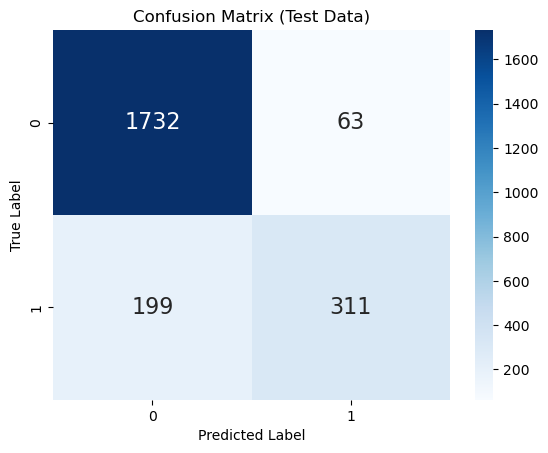

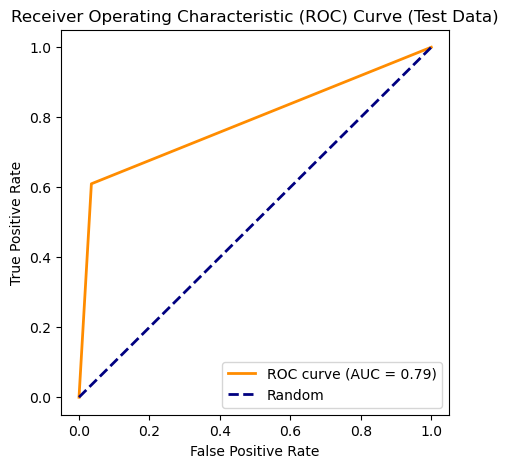

In [585]:
# # Evaluate the model using the evaluate_model function
# model_name = 'Random Forest'
# model_number='1'

# # Assume you have an empty DataFrame or None before calling the function
# results_df = None

# Call the function for the first time
#results_df = evaluate_model(X_train, y_train, X_test, y_test, 'Random Forest', '1', results_df)
#results_df = evaluate_model(model, X_train, y_train, X_test, y_test, 'Model1', '1', results_df)
results_df = evaluate_model(y_test, y_pred, y_train, y_pred_train, 'Model', '1', results_df)

# results_df = evaluate_model(X_train, y_train,X_test, y_test, y_pred, model_name,model_number)

In [530]:
results_df

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Your Model,0.70362,0.986832,0.831551,0.609804,0.886334,0.787353


In [531]:
#Model 1.b with oversampling: try random forest with resampling 

# Oversample the minority class using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

model1b = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Fit the model on the resampled data
model1b.fit(X_resampled, y_resampled)


y_pred1b = model1b.predict(X_test)
y_pred1b_train = model1b.predict(X_train)

print("Accuracy:", accuracy_score(y_test, y_pred1b))
print("Classification Report:\n", classification_report(y_test, y_pred1b))




Accuracy: 0.881995661605206
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      1795
           1       0.76      0.68      0.72       510

    accuracy                           0.88      2305
   macro avg       0.84      0.81      0.82      2305
weighted avg       0.88      0.88      0.88      2305



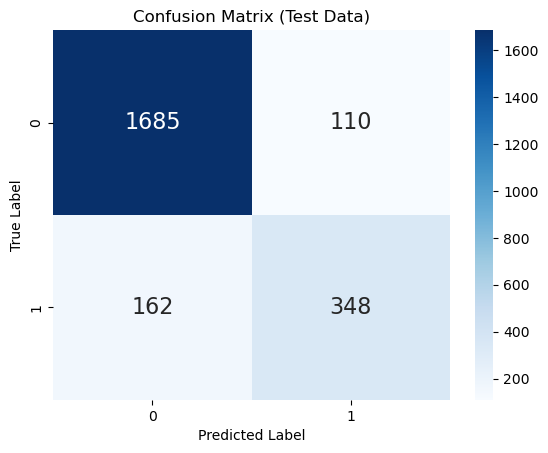

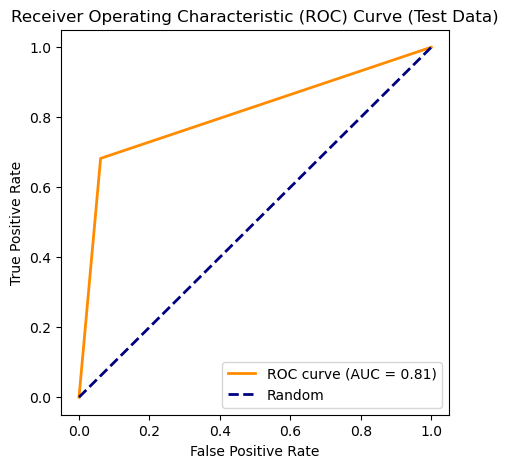

In [586]:
# model_name = 'Random Forest with oversampling'
# model_number='1b'
# results_df = evaluate_model(X_train, y_train, X_test, y_test, model_name, model_number, results_df)
#results_df = evaluate_model(y_test, y_pred1b, model_name,model_number,results_df)

results_df = evaluate_model(y_test, y_pred1b, y_train, y_pred1b_train, 'Model2', '2', results_df)


In [533]:
results_df

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Your Model,0.703620,0.986832,0.831551,0.609804,0.886334,0.787353
1,2,Your Model2,0.719008,0.984623,0.759825,0.682353,0.881996,0.810536


In [534]:
#Model 1.2: Try undersampling


# Undersample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_underresampled, y_underresampled = undersampler.fit_resample(X_train, y_train)


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


model.fit(X_underresampled, y_underresampled)


y_pred1c = model.predict(X_test)
y_pred1c_train = model.predict(X_train)

print("Accuracy:", accuracy_score(y_test, y_pred1c))
print("Classification Report:\n", classification_report(y_test, y_pred1c))

Accuracy: 0.8047722342733189
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.79      0.86      1795
           1       0.54      0.84      0.66       510

    accuracy                           0.80      2305
   macro avg       0.74      0.82      0.76      2305
weighted avg       0.86      0.80      0.82      2305



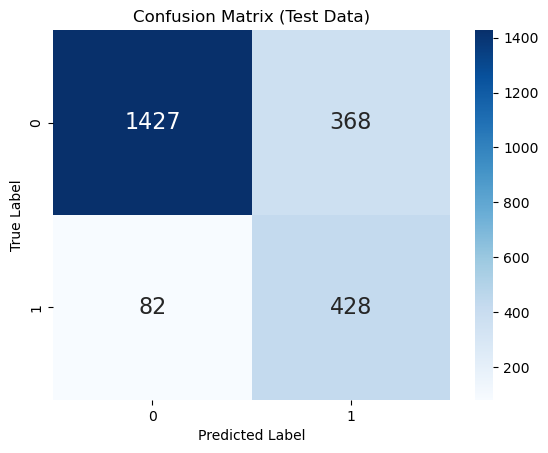

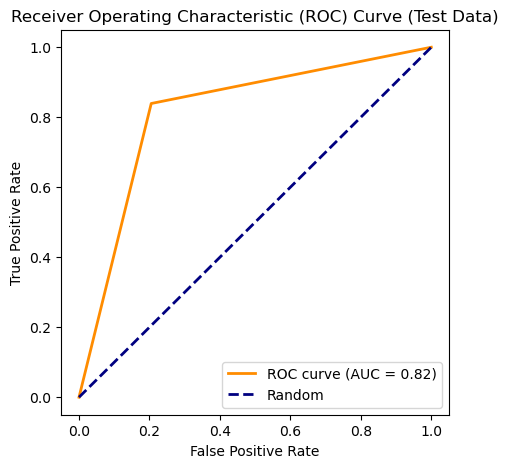

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Your Model,0.703620,0.986832,0.831551,0.609804,0.886334,0.787353
1,2,Your Model2,0.719008,0.984623,0.759825,0.682353,0.881996,0.810536
2,3,Your Model3,0.655436,0.771325,0.537688,0.839216,0.804772,0.817101
3,4,XGBoost,0.713387,0.868093,0.658375,0.778431,0.861605,0.831834
4,3,Model3,0.655436,0.771325,0.537688,0.839216,0.804772,0.817101


In [584]:
model_name = 'Random Forest with undersampling'
model_number='1c'


results_df = evaluate_model(y_test, y_pred1c, y_train, y_pred1c_train, 'Model3', '3', results_df)
results_df

In [536]:
#Model 2.1 :XGBoost

model2 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', xgb.XGBClassifier(random_state=42))])

param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__scale_pos_weight': [None, 4]  # Adjusted scale_pos_weight values
}

grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)


y_pred2 = grid_search.best_estimator_.predict(X_test)
y_pred2_train = grid_search.best_estimator_.predict(X_train)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 4}
Accuracy: 0.8616052060737527
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      1795
           1       0.66      0.78      0.71       510

    accuracy                           0.86      2305
   macro avg       0.80      0.83      0.81      2305
weighted avg       0.87      0.86      0.87      2305



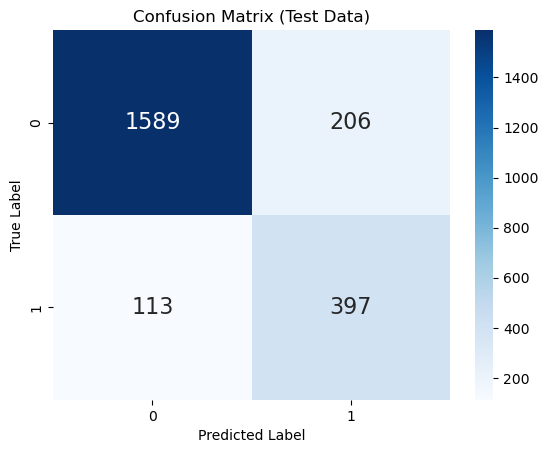

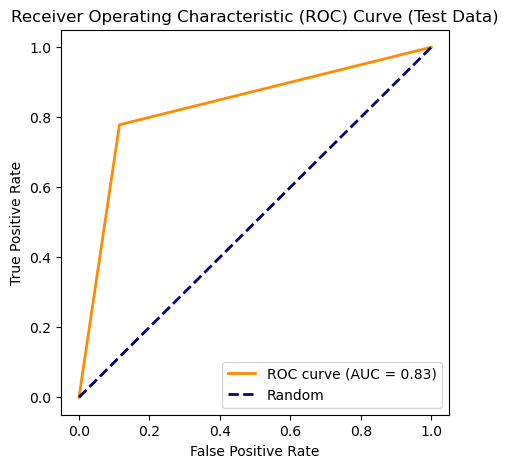

,Model No.,Model,F1 Score (Test Data),F1 Score (Train Data),Precision,Recall,Accuracy,AUC
0,1,Your Model,0.703620,0.986832,0.831551,0.609804,0.886334,0.787353
1,2,Your Model2,0.719008,0.984623,0.759825,0.682353,0.881996,0.810536
2,3,Your Model3,0.655436,0.771325,0.537688,0.839216,0.804772,0.817101
3,4,XGBoost,0.713387,0.868093,0.658375,0.778431,0.861605,0.831834


In [537]:
model_name = 'XGBoost'
model_number='2'
results_df = evaluate_model(y_test, y_pred2, y_train, y_pred2_train, 'XGBoost', '4', results_df)
results_df

In [591]:
from xgboost import XGBClassifier


def ensemble_features_classifier(model, name, X, y, n_splits=5, random_state=42):
    '''Gets the features importance for a designated classifier model and displays it as a graph for each cross-validation fold.
    Input: model, title (name) to be displayed in the graph title, X, y, n_splits (number of folds), random_state
    Output: A feature importance graph for each fold
    '''

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        if isinstance(model, XGBClassifier):
            features = model.get_booster().get_score(importance_type='weight')
        elif isinstance(model, RandomForestClassifier):
            features = list(zip(X_train.columns, model.feature_importances_))
        else:
            raise ValueError("Unsupported classifier type. Please use XGBClassifier or RandomForestClassifier.")

        features.sort(key=lambda x: x[1], reverse=False)

        features, values = zip(*features)

        sns.set_style('white')
        plt.figure(figsize=(10, 8))
        plt.barh(features, values, label=f'Fold {i+1}', color='lightblue')

        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance for {name} - Fold {i+1}')
        plt.legend()
        sns.despine()

        plt.show()




In [592]:
ensemble_features_classifier(best_model.named_steps['classifier'], 'XGBoost', X_train, y_train)

AttributeError: 'XGBClassifier' object has no attribute 'named_steps'

In [405]:
#Model2.2 :XGBoost with oversampling

model2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', xgb.XGBClassifier(random_state=42))])


param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__scale_pos_weight': [None, 4]  # Adjusted scale_pos_weight values
}

grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)

print("Best Hyperparameters:", grid_search.best_params_)

# Obtain the best estimator from the grid search
best_model = grid_search.best_estimator_

y_pred2b = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred2b))
print("Classification Report:\n", classification_report(y_test, y_pred2b))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': None}
Accuracy: 0.8611713665943601
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      1795
           1       0.66      0.76      0.71       510

    accuracy                           0.86      2305
   macro avg       0.80      0.82      0.81      2305
weighted avg       0.87      0.86      0.86      2305



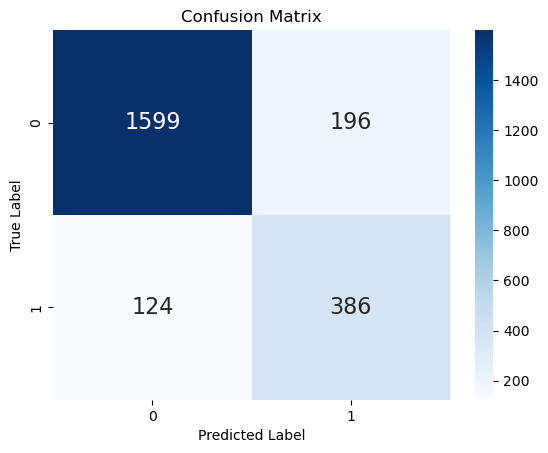

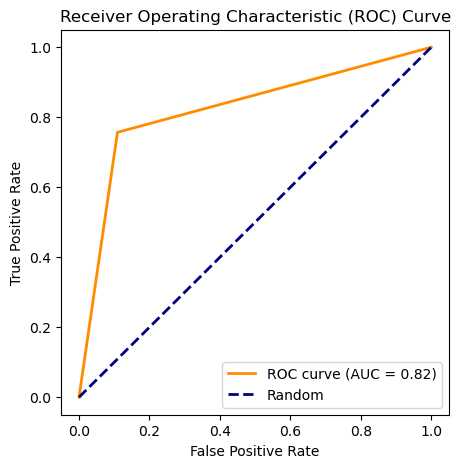

,Model No.,Model,F1 Score,Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.703620,0.831551,0.609804,0.886334,0.787353
1,1b,Random Forest with oversampling,0.719008,0.759825,0.682353,0.881996,0.810536
2,1c,Random Forest with undersampling,0.655436,0.537688,0.839216,0.804772,0.817101
3,2,XGBoost,0.713387,0.658375,0.778431,0.861605,0.831834
4,2b,XGBoost with oversampling,0.706960,0.663230,0.756863,0.861171,0.823835
5,2,XGBoost,0.713387,0.658375,0.778431,0.861605,0.831834
6,2b,XGBoost with oversampling,0.706960,0.663230,0.756863,0.861171,0.823835


In [406]:
model_name = 'XGBoost with oversampling'
model_number='2b'

results_df = evaluate_model(y_test, y_pred2b, model_name,model_number,results_df)
results_df

In [407]:
#Model3: Bagging

bagging_model = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                                  n_estimators=5) 

bagging_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', bagging_model)])

bagging_pipeline.fit(X_train, y_train)

y_pred3 = bagging_pipeline.predict(X_test)


                            
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("Classification Report:\n", classification_report(y_test, y_pred3))

Accuracy: 0.8785249457700651
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      1795
           1       0.87      0.53      0.66       510

    accuracy                           0.88      2305
   macro avg       0.87      0.75      0.79      2305
weighted avg       0.88      0.88      0.87      2305



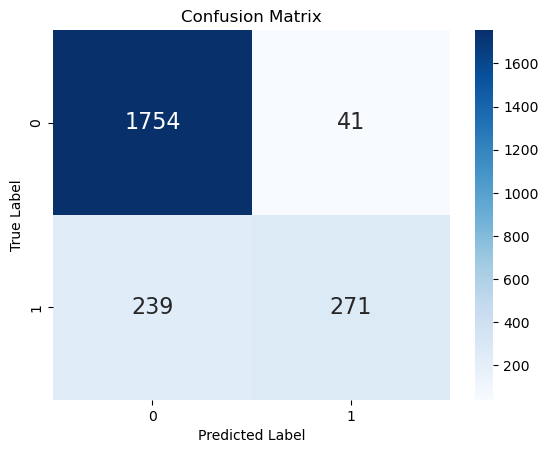

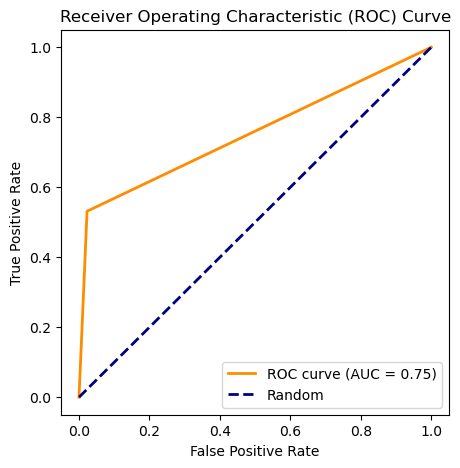

,Model No.,Model,F1 Score,Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.703620,0.831551,0.609804,0.886334,0.787353
1,1b,Random Forest with oversampling,0.719008,0.759825,0.682353,0.881996,0.810536
2,1c,Random Forest with undersampling,0.655436,0.537688,0.839216,0.804772,0.817101
3,2,XGBoost,0.713387,0.658375,0.778431,0.861605,0.831834
4,2b,XGBoost with oversampling,0.706960,0.663230,0.756863,0.861171,0.823835
5,2,XGBoost,0.713387,0.658375,0.778431,0.861605,0.831834
6,2b,XGBoost with oversampling,0.706960,0.663230,0.756863,0.861171,0.823835
7,3,Bagging,0.659367,0.868590,0.531373,0.878525,0.754266


In [408]:
model_name = 'Bagging'
model_number='3'

results_df = evaluate_model(y_test, y_pred3, model_name,model_number,results_df)
results_df

In [409]:
#Model 4 Log reg


log_reg_model = LogisticRegression(random_state=42)

log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier',log_reg_model)])

log_reg_pipeline.fit(X_train, y_train)

y_pred4 = log_reg_pipeline.predict(X_test)


                            
print("Accuracy:", accuracy_score(y_test, y_pred4))
print("Classification Report:\n", classification_report(y_test, y_pred4))

Accuracy: 0.789587852494577
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88      1795
           1       0.59      0.17      0.26       510

    accuracy                           0.79      2305
   macro avg       0.69      0.57      0.57      2305
weighted avg       0.76      0.79      0.74      2305



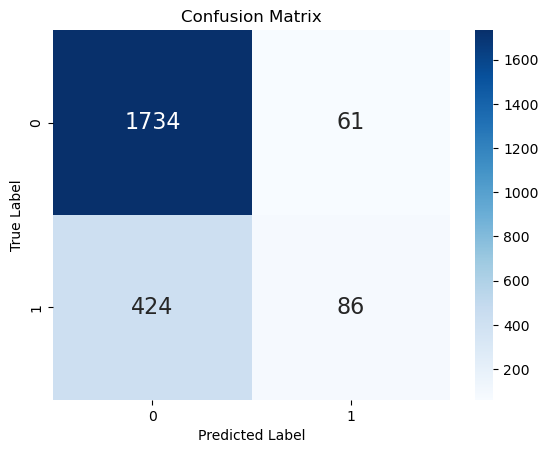

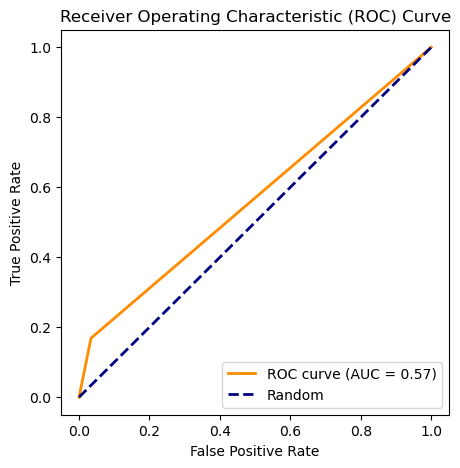

,Model No.,Model,F1 Score,Precision,Recall,Accuracy,AUC
0,1,Random Forest,0.703620,0.831551,0.609804,0.886334,0.787353
1,1b,Random Forest with oversampling,0.719008,0.759825,0.682353,0.881996,0.810536
2,1c,Random Forest with undersampling,0.655436,0.537688,0.839216,0.804772,0.817101
3,2,XGBoost,0.713387,0.658375,0.778431,0.861605,0.831834
4,2b,XGBoost with oversampling,0.706960,0.663230,0.756863,0.861171,0.823835
5,2,XGBoost,0.713387,0.658375,0.778431,0.861605,0.831834
6,2b,XGBoost with oversampling,0.706960,0.663230,0.756863,0.861171,0.823835
7,3,Bagging,0.659367,0.868590,0.531373,0.878525,0.754266
8,4,Logistic Regression,0.261796,0.585034,0.168627,0.789588,0.567322


In [410]:
model_name = 'Logistic Regression'
model_number='4'

results_df = evaluate_model(y_test, y_pred4, model_name,model_number,results_df)
results_df

In [421]:
#best model - xgboost and random forest with oversampling performed the best,
#will go with xgboost since it has a higher auc 
best_model = xgb_model
best_model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

AttributeError: 'XGBClassifier' object has no attribute 'named_steps'

In [576]:
eatures_after_preprocessing = best_model.named_steps['preprocessor'].get_feature_names_out(input_features=X_resampled.columns)

# Create a mapping of original feature names to their corresponding indices after preprocessing
feature_name_mapping = dict(zip(features_after_preprocessing, X_resampled.columns))


importances = best_model.named_steps['classifier'].feature_importances_

importances_named = {feature_name_mapping.get(feature, feature): importance for feature, importance in zip(features_after_preprocessing, importances)}

AttributeError: 'XGBClassifier' object has no attribute 'named_steps'

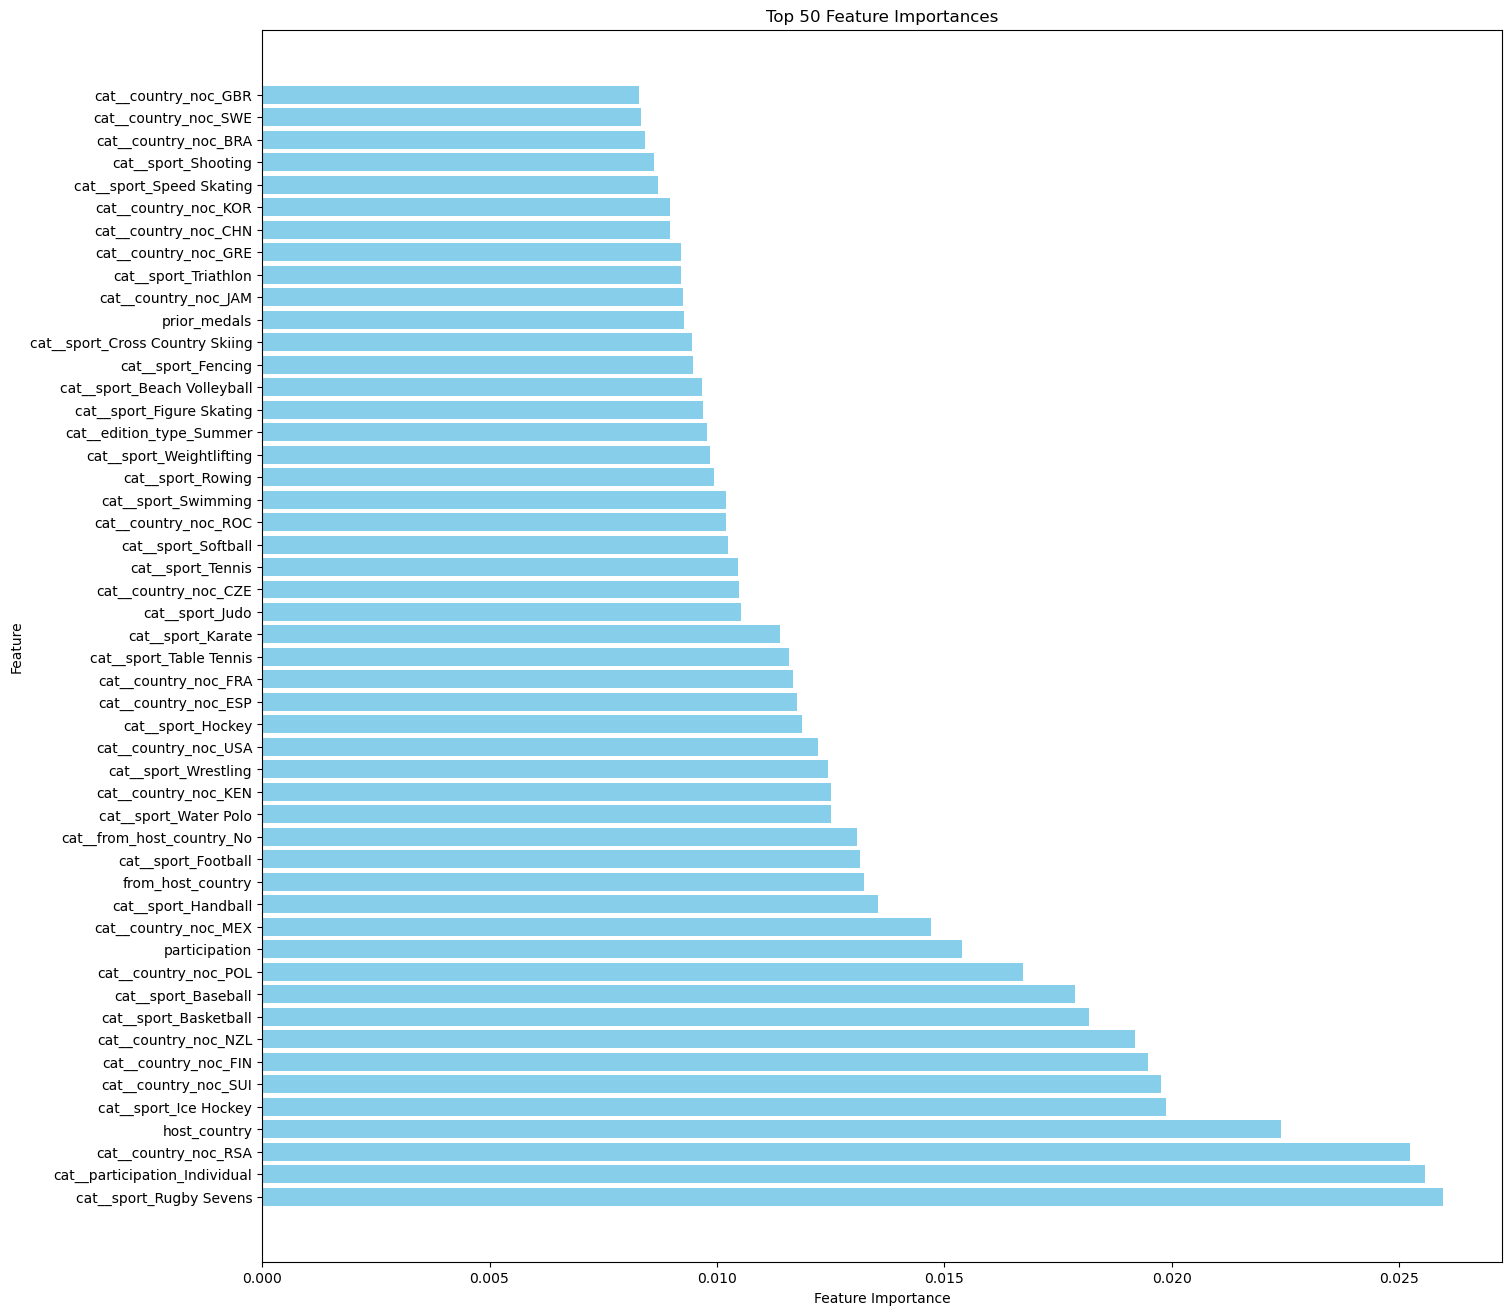

In [419]:
# Sort features based on importance
sorted_importances = sorted(importances_named.items(), key=lambda x: x[1], reverse=True)

# Extract top 50 features and their importances
top_features = [feature for feature, importance in sorted_importances[:50]]
top_importances = [importance for feature, importance in sorted_importances[:50]]


plt.figure(figsize=(16, 16))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances')
plt.show()